In [1]:
import pandas as pd

from datetime import datetime
from datetime import date

import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re

import unicodedata
import math
from itertools import cycle
import xlsxwriter
import pyodbc
from datetime import timedelta
import matplotlib

import random
from IPython.display import display, HTML

import sys

import tkinter as tk
from tkinter import ttk
from tkinter import PhotoImage
from PIL import ImageTk, Image
import os

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

def calcula_dv(rut_base):
    # CONVERTIR EL RUT BASE A UNA CADENA Y REVERTIRLA
    reversed_digits = list(map(int, str(rut_base)[::-1]))
    # DEFINIR LOS FACTORES (2..7) QUE SE REPITEN EN CICLO
    factors = list(range(2, 8))
    # CALCULAR LA SUMA DE LOS PRODUCTO
    suma = sum(d * f for d, f in zip(reversed_digits, factors * (len(reversed_digits) // len(factors) + 1)))
    # CALCULA DV
    dv = (-suma) % 11
    return 'K' if dv == 10 else str(dv)

def remove_leading_zeros(rut):
    rut_part, dv = rut.split('-')
    rut_part = rut_part.lstrip('0')
    if not rut_part:
        rut_part = '0'
    return f"{rut_part}-{dv}"

def reemplazar_k(identificador):
    return identificador[:-1:] + identificador[-1].upper()

def separar_rut(numero):
    numero_str = str(numero)
    # TOMAR EL ULTIMO DIGITO
    parte_numerica = numero_str[:-1]
    digito_verificador = numero_str[-1]
    # FORMTATEAR GUION
    rut_formateado = f"{parte_numerica}-{digito_verificador}"
    return rut_formateado

pd.options.display.float_format = "{:,.0f}".format

In [2]:
%store -r df_saldo_caja
%store -r df_custodia_detalle
%store -r df_operaciones
%store -r df_DATOS_clientes
%store -r df_APORET_detalle  
%store -r df_muestra2 
%store -r m   

In [3]:
df_operaciones.sample()

,NUM_CUENTA,IDENTIFICADOR,NOMBRE_CLIENTE,NOMBRE_ASESOR,FECHA_OPERACION,COD_TIPO_OPERACION,DSC_OPERACION_CONCEPTO,COD_MONEDA_OP,NEMOTECNICO,DSC_INSTRUMENTO,COD_SUB_CLASE_INSTRUMENTO,CANTIDAD,MONTO,MONTO_OPERACION,DOLAR_OBS,MONTO_CLP
595708,19005855/60,19005855-7,Esteban Bozzo Daza,RACIONAL .,2023-02-03,CIFM,COMPRA FONDOS CB,CLP,CFIETFCD,FI ETF SINGULAR CHILE CORTA DURACION,CFI,12,"13,176","13,176",781,"13,176"


## CRITERIOS APORTES Y RESCATES

### CRITERIOS APORTES 

#### 1. APORTE SUPERA UMBRAL 

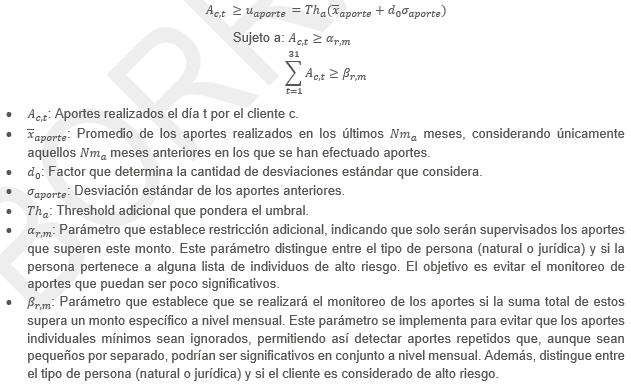

**PARÁMETROS DIFERENCIADOS:**
Según el tipo de persona son los parámetros $\alpha$ y $\beta$, que definen los aportes a monitorear 
al igual que si la persona pertenece a una lista de alto riesgo como:

&emsp;- Personas Expuestas Políticamente <br>
&emsp;- Causa Judicial por Delito Precedente <br>
&emsp;- Persona Jurídica o Natural residente en comuna con Zona Franca <br>
&emsp;- Listado de países y territorios no cooperantes según la OCDE y GAFI <br>
&emsp;- Personas Jurídicas con giro catalogado como riesgoso <br>

<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>Alpha</th>
            <th>Beta</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>500,000</td>
            <td>8,000,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td>BAJO</td>
            <td>1,000,000</td>
            <td>16,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td>ALTO</td>
            <td>3,500,000</td>
            <td>35,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td>BAJO</td>
            <td>5,000,000</td>
            <td>50,000,000</td>
        </tr>
    </tbody>
</table>



In [4]:
# ASIGNAR ALPHA Y BETA
def asignar_limites(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'ALTO':
            return 500_000, 8_000_000  # Alpha_NR, Beta_NR
        else:
            return 1_000_000, 16_000_000  # Alpha_N, Beta_N
    elif row['TIPO_PER'] == 'JURIDICA':
        if row['RIESGO'] == 'ALTO':
            return 3_500_000, 35_000_000  # Alpha_NR, Beta_NR
        else:
            return 7_000_000, 70_000_000  # Alpha_N, Beta_N

**SUB DF DE APORTES A MONITOREAR:**
De todos los aportes disponibles se toma una porción de los aportes dados los parámetros $\alpha$ y $\beta$,
se arma estadística del promedio, desviación estándar de los aportes.

In [5]:
Aportes = df_APORET_detalle[df_APORET_detalle["CARGO_ABONO"] == 'A']
df_Aportes_copia = Aportes.copy()
df_Aportes_copia['FECHA_MOVIMIENTO'] = pd.to_datetime(df_Aportes_copia['FECHA_MOVIMIENTO'])  
df_Aportes_copia['MES'] = df_Aportes_copia['FECHA_MOVIMIENTO'].dt.to_period('M') 

# MERGE CON DF_MUESTRA2 PARA OBTENER 'TIPO_PER' Y 'RIESGO' ASOCIADOS AL 'IDENTIFICADOR'
df_Aportes_copia = df_Aportes_copia.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left')

# CREA COLUMNAS ALPHA Y BETA, filtrar aportes > ALPHA
df_Aportes_copia[['Alpha', 'Beta']] = df_Aportes_copia.apply(asignar_limites, axis=1, result_type='expand')
df_Aportes_copia_filtrado = df_Aportes_copia[df_Aportes_copia['MONTO_CLP'] >= df_Aportes_copia['Alpha']]

# RESUMEN POR CLIENTE Y MES, SUMANDO LOS MONTOS
df_resumen_A = df_Aportes_copia.groupby(['IDENTIFICADOR', 'MES'])['MONTO_CLP'].sum().reset_index()
# IDENTIFICAR LOS MESES DONDE EL TOTAL SUPERA BETA
meses_superan_Beta_A = df_resumen_A.merge(df_Aportes_copia[['IDENTIFICADOR', 'MES', 'Beta']].drop_duplicates(),
                                          on=['IDENTIFICADOR', 'MES'])
meses_superan_Beta_A = meses_superan_Beta_A[meses_superan_Beta_A['MONTO_CLP'] >= meses_superan_Beta_A['Beta']][['IDENTIFICADOR', 'MES']]
df_Aportes_copia_superan_Beta = df_Aportes_copia.merge(meses_superan_Beta_A, on=['IDENTIFICADOR', 'MES'])

# DF COMBINADO, CRITERIO ALFA Y BETA
df_combinado_A = pd.concat([df_Aportes_copia_filtrado, df_Aportes_copia_superan_Beta]).drop_duplicates()
# FILTRADO ADICIONAL APORTES SOBRE monto_test
monto_test = 100_000
df_combinado_A = df_combinado_A[df_combinado_A['MONTO_CLP'] >= monto_test]

# COLUMNA AUXILIAR MES_NUM
df_combinado_A['MES_NUM'] = df_combinado_A['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)
df_combinado_A['MES_NUM'] = df_combinado_A['MES_NUM'] - df_combinado_A['MES_NUM'].min() + 1

<table>
  <thead>
    <tr>
      <th>Nm_A</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
  </tbody>
</table>
le>
  

In [6]:
# PARAMETROS ESTADÍSTICA
Nm_A = 4

# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_combinado_A = df_combinado_A.sort_values(by=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'])
df_combinado_A['MES_NUM2'] = (df_combinado_A.groupby('IDENTIFICADOR')['MES_NUM']
                             .rank(method='dense').astype(int))
# SELECCIONA LOS N MESES ANTERIORES
resultados = []
for identificador, grupo in df_combinado_A.groupby('IDENTIFICADOR'):

    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        
        # FILTRAR LAS FILAS DE N MESES ANTERIORES
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_A)]
        promedio_aportes = ultimos_n_meses['MONTO_CLP'].mean()
        std_aportes = ultimos_n_meses['MONTO_CLP'].std()
        # AGREGA RESUTLADO AL DF
        resultados.append({
            'IDENTIFICADOR': identificador,
            'MES': mes_actual,
            'promedio_aportes': promedio_aportes,
            'std_aportes': std_aportes
        })

# CREAR DF
df_resultados_A = pd.DataFrame(resultados)
df_resultados_A = df_resultados_A.drop_duplicates(subset=['IDENTIFICADOR','MES'])

for identifier in df_resultados_A['IDENTIFICADOR'].unique():
    ## INDICES N/A
    indices = df_resultados_A[df_resultados_A['IDENTIFICADOR'] == identifier].index[:Nm_A]
    df_resultados_A.loc[indices, ['promedio_aportes', 'std_aportes']] = 'n/a'

df_grouped_A = df_resultados_A.copy()
df_grouped_A['promedio_aportes'] = pd.to_numeric(df_grouped_A['promedio_aportes'], errors='coerce')
df_grouped_A['std_aportes'] = pd.to_numeric(df_grouped_A['std_aportes'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\2514187367.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'n/a' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados_A.loc[indices, ['promedio_aportes', 'std_aportes']] = 'n/a'


In [7]:
df_grouped_A[df_grouped_A['IDENTIFICADOR'] == '16532670-9']

,IDENTIFICADOR,MES,promedio_aportes,std_aportes


**APORTE SUPERA EL UMBRAL:** $d_0$ cantidad de desviaciones estándar dentro del umbral

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Nm_A</td>
      <td>4</td>
      <td>Número meses de datos de aportes para el umbral</td>
    </tr>
    <tr>
      <td>$d_0$</td>
      <td>3.5</td>
      <td>Cantidad de std</td>
    </tr>
    <tr>
      <td>$th_a$</td>
      <td>1.5</td>
      <td>Threshold en caso de que la std sea nula para hacer más robusto el umbral</td>
    </tr>
    <tr>
      <td>$th_{nstd}$</td>
      <td>2</td>
      <td>Threshold adicional al umbral, lo hace más conservador en caso de que la std sea baja y así el umbral es más robusto</td>
    </tr>
  </tbody>
</table>

In [8]:
# PARÁMETROS
n_meses = 4
d_0 = 3.5
th_a = 1.25
th_nstd = 2

In [9]:
alertas_aporte = []

for id_cliente in df_grouped_A['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_A[df_grouped_A['IDENTIFICADOR'] == id_cliente]
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES').reset_index(drop=True)
    # ITERAR DESDE n_meses HASTA FINAL DF
    for i in range(n_meses, len(df_cliente)):
        # MES ACTUAL Y DATOS CLIENTES
        mes_actual = df_cliente.iloc[i]['MES']
        promedio_aportes = df_cliente.iloc[i]['promedio_aportes']
        std_aportes = df_cliente.iloc[i]['std_aportes']

        # APORTES MES ACTUAL
        aportes_actuales_filtro = df_combinado_A[
            (df_combinado_A['MES'] == mes_actual) &
            (df_combinado_A['IDENTIFICADOR'] == id_cliente)
        ]

        # ITERA SOBRE APORTES
        for _, aporte_fila in aportes_actuales_filtro.iterrows():
            aporte_actual = aporte_fila['MONTO_CLP']
            fecha_movimiento = aporte_fila['FECHA_MOVIMIENTO']

            # UMBRAL
            if std_aportes == 0:
                umbral = promedio_aportes * th_nstd # THRESHOLD SIN STD
            else:
                umbral = th_a *(promedio_aportes + d_0 * std_aportes)  # NORMAL
            
            # OBTIENE APORTES SOBRE UMBRAL
            if aporte_actual > umbral:
                alertas_aporte.append({
                    'MES': mes_actual,
                    'IDENTIFICADOR': id_cliente,
                    'aporte_actual': aporte_actual,
                    'fecha_aporte': fecha_movimiento,
                    'promedio_aportes': promedio_aportes,
                    'std_aportes': std_aportes,
                    'umbral': umbral
                })

df_alerta_APORTESUPERAUMBRAL = pd.DataFrame(alertas_aporte)

In [10]:
df_alerta_APORTESUPERAUMBRAL = pd.merge(df_alerta_APORTESUPERAUMBRAL, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [11]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_APORTESUPERAUMBRAL['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_APORTESUPERAUMBRAL['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_APORTESUPERAUMBRAL.shape[0]}\n",
      df_alerta_APORTESUPERAUMBRAL.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 399 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 1.47 % 
Cantidad de veces que se levanta la señal: 744
 MES
2023-05      1
2023-06      6
2023-07     16
2023-08     16
2023-09     23
2023-10     19
2023-11     24
2023-12     25
2024-01     44
2024-02    101
2024-03     56
2024-04     22
2024-05     63
2024-06     46
2024-07     54
2024-08     60
2024-09     57
2024-10    111
Freq: M, Name: count, dtype: int64


#### 3. CRITERIO APORTES SIMILARES EN MONTOS

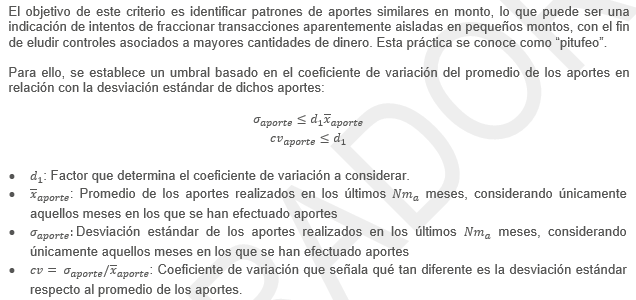

In [12]:
## COEFICIENTE DE VARIACION
df_grouped_A = df_combinado_A.groupby(['MES', 'IDENTIFICADOR']).agg(
    promedio_aportes=('MONTO_CLP', 'mean'),
    std_aportes=('MONTO_CLP', 'std'),
    count_aportes=('MONTO_CLP', 'size')
).reset_index()

d_1 = 0.12
cant_minima_aportes = 5
df_grouped_A['coef_var'] = df_grouped_A['std_aportes'] / df_grouped_A['promedio_aportes']
df_grouped_A['alerta'] = (df_grouped_A['coef_var'] <= d_1) & (df_grouped_A['count_aportes'] >= cant_minima_aportes)

# FILTRA LOS DE LA ALERTA
df_alerta_APORTESIMILARES = df_grouped_A[df_grouped_A['alerta']]
df_alerta_APORTESIMILARES = df_alerta_APORTESIMILARES.reset_index(drop=True)

In [13]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_APORTESIMILARES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_APORTESIMILARES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_APORTESIMILARES.shape[0]}\n",
      df_alerta_APORTESIMILARES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 170 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.63 % 
Cantidad de veces que se levanta la señal: 237
 MES
2023-01     6
2023-02     4
2023-03     2
2023-04     4
2023-05     8
2023-06     5
2023-07    15
2023-08     7
2023-09     6
2023-10     8
2023-11    14
2023-12    11
2024-01    18
2024-02     6
2024-03    17
2024-04    13
2024-05    16
2024-06     9
2024-07    24
2024-08    14
2024-09    11
2024-10    19
Freq: M, Name: count, dtype: int64


In [14]:
df_alerta_APORTESIMILARES = pd.merge(df_alerta_APORTESIMILARES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [15]:
############### COLOR ##################
df_alerta_APORTESIMILARES_color = df_alerta_APORTESIMILARES.copy()
unique_ids = df_alerta_APORTESIMILARES_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_APORTESIMILARES_color = (
    df_alerta_APORTESIMILARES_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

#df_alerta_APORTESIMILARES_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\3706790349.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\3706790349.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


#### 4.	APORTES MAYORES AL PATRIMONIO VALORIZADO DEL CLIENTE

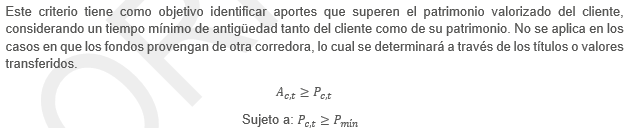

In [16]:
# ASIGNAR ALPHA Y BETA
def asignar_limites_aporte_mayor_custodia(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'ALTO':
            return 3_000_000
        else:
            return 7_000_000
    elif row['TIPO_PER'] == 'JURIDICA':
        return 50_000_000

In [17]:
df_custodia_detalle = df_custodia_detalle.copy()
df_custodia_consolidado = df_custodia_detalle.groupby(['IDENTIFICADOR', 'fecha_cierre'], as_index=False).sum('VALOR_MERCADO_CLP')
df_custodia_consolidado = df_custodia_consolidado[['IDENTIFICADOR','fecha_cierre','VALOR_MERCADO_CLP']]

In [18]:
df_diario_A = df_combinado_A.groupby(['IDENTIFICADOR', 'FECHA_MOVIMIENTO']).agg(
    MONTO_CLP=('MONTO_CLP', 'sum')
).reset_index()

In [19]:
df_diario_A.sample()

,IDENTIFICADOR,FECHA_MOVIMIENTO,MONTO_CLP
31366,19361360-8,2023-06-28,"1,271,353"


In [20]:
df_custodia_consolidado_copia = df_custodia_consolidado.merge(
    df_muestra2[['IDENTIFICADOR', 'RIESGO','TIPO_PER','NOMBRE_CLIENTE']], 
    on='IDENTIFICADOR', 
    how='left'  
).fillna(' ')

# CREA COLUMNAS index
df_custodia_consolidado_copia['index_custodia'] = df_custodia_consolidado_copia.apply(asignar_limites_aporte_mayor_custodia, axis=1, result_type='expand')

In [21]:
df_diario_A.sample()

,IDENTIFICADOR,FECHA_MOVIMIENTO,MONTO_CLP
24865,18168983-8,2024-08-09,"4,000,000"


In [22]:
# MERGE df_custodia_consolidado y df_APORET_detalle_2 por IDENTIFICADOR y fechas
df_merged = pd.merge(df_custodia_consolidado_copia, 
                     df_diario_A, 
                     left_on=['IDENTIFICADOR', 'fecha_cierre'], 
                     right_on=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'], 
                     how='inner')

### APORTE (MONTO_CLP) mayor a custodia (VALOR_MERCADO_CLP)
cond1 = df_merged['MONTO_CLP'] > df_merged['VALOR_MERCADO_CLP']
cond2 = df_merged['VALOR_MERCADO_CLP'] > df_merged['index_custodia']

df_aporte_mayor_custodia = (df_merged[cond1 & cond2])


In [23]:
del df_aporte_mayor_custodia['FECHA_MOVIMIENTO']
del df_aporte_mayor_custodia['index_custodia']

In [24]:
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M') 

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\3286359461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')


In [25]:
df_aporte_mayor_custodia

,IDENTIFICADOR,fecha_cierre,VALOR_MERCADO_CLP,RIESGO,TIPO_PER,NOMBRE_CLIENTE,MONTO_CLP,MES
386,13996453-5,2024-10-15,11550097,,NATURAL,Sergio Andres Díaz Pizarro,"17,869,266",2024-10
408,14120511-0,2024-10-28,19800630,,NATURAL,Rafael Peñaloza Tallia,"20,000,000",2024-10
557,15316478-9,2024-10-17,48228288,,NATURAL,Jaime Espinoza Matamala,"90,000,000",2024-10
632,15591380-0,2024-10-24,37537796,,NATURAL,BETTINA STENGEL USLAR,"37,928,000",2024-10
669,15680139-9,2024-10-11,14291795,,NATURAL,Constanza Vergara Vidal,"15,000,000",2024-10
677,15717613-7,2024-10-22,84236412,ALTO,NATURAL,RENÉ ENRIQUE WÖHLK WÖHLK,"85,000,000",2024-10
710,15911690-5,2024-10-30,15330352,,NATURAL,Natalia Arriagada Arroyo,"32,486,406",2024-10
923,16612044-6,2024-10-18,103997407,,NATURAL,JAIME ANDRÉS ARENAS GUARDIA,"140,000,000",2024-10
951,16725854-9,2024-10-18,22517791,,NATURAL,MATIAS PINOCHET AUBELE,"25,000,000",2024-10
954,16741581-4,2024-10-25,8102307,,NATURAL,Cristian Ramirez Diaz,"17,945,196",2024-10


In [26]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_aporte_mayor_custodia['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_aporte_mayor_custodia['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_aporte_mayor_custodia.shape[0]}\n",
      df_aporte_mayor_custodia.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 35 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.13 % 
Cantidad de veces que se levanta la señal: 36
 MES
2024-10    36
Freq: M, Name: count, dtype: int64


In [27]:
df_aporte_mayor_custodia_color = df_aporte_mayor_custodia.copy()

unique_ids = df_aporte_mayor_custodia_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
def color_aporte_vs_custodia(row):
    aporte_vs_custodia = row['MONTO_CLP'] / row['VALOR_MERCADO_CLP']
    if aporte_vs_custodia > 1.5:
        return ['background-color: red'] * len(row)  # Rojo claro
    elif aporte_vs_custodia > 1.2:
        return ['background-color: orange'] * len(row)  # Rojo claro
    else:
        return [''] * len(row)


df_aporte_mayor_custodia_color = (
    df_aporte_mayor_custodia_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
    .apply(color_aporte_vs_custodia, axis=1, subset=['VALOR_MERCADO_CLP', 'MONTO_CLP'])
)


C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\2881352000.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\2881352000.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


#### 5.0 CRITERIO APORTES PRIMER DÍA CONSIDERABLEMENTE ALTO

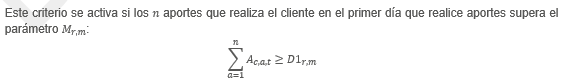

<table>
  <thead>
    <tr>
      <th>TIPO_PER</th>
      <th>RIESGO</th>
      <th>D1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>NATURAL</td>
      <td>ALTO</td>
      <td>10 000 000</td>
    </tr>
    <tr>
      <td>NATURAL</td>
      <td>&nbsp;</td>
      <td>40 000 000</td>
    </tr>
    <tr>
      <td>JURIDICO</td>
      <td>&nbsp;</td>
      <td>250 000 000</td>
    </tr>
  </tbody>
</table>


In [28]:
# M SEGÚN SEGMENTO
def asignar_M(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'ALTO':
            return 3_000_000 # Alpha_NR, Beta_NR
        else:
            return 7_000_000  # Alpha_N, Beta_N
    elif row['TIPO_PER'] == 'JURIDICA':
        return 50_000_000  # Alpha_J, Beta_J

In [29]:
df_combinado_A['M'] = df_combinado_A.apply(asignar_M, axis=1)
df_combinado_A_sorted = df_combinado_A.sort_values(by='FECHA_MOVIMIENTO')
Primer_Dia_Aporte_Cliente = df_combinado_A_sorted.groupby('IDENTIFICADOR')['FECHA_MOVIMIENTO'].first().reset_index()

# UNIR CON EL DATAFRAME ORIGINAL PARA OBTENER LOS MOVIMIENTOS CORRESPONDIENTES AL primer dia
Movimientos_Primer_Dia = df_combinado_A_sorted.merge(Primer_Dia_Aporte_Cliente, 
                                                     on=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'], 
                                                     how='inner')

# SUMAR MONTOS PRIMER DIA
Suma_Primer_Aporte_Cliente = Movimientos_Primer_Dia.groupby('IDENTIFICADOR').agg(
    {'MONTO_CLP': 'sum', 'NOMBRE_CLI': 'first', 'FECHA_MOVIMIENTO': 'first', 'M': 'first'}).reset_index()

# FILTRAR
Señal_Primer_Aporte_Grande = Suma_Primer_Aporte_Cliente[Suma_Primer_Aporte_Cliente['MONTO_CLP'] >= Suma_Primer_Aporte_Cliente['M']]
Señal_Primer_Aporte_Grande_Alerta = Señal_Primer_Aporte_Grande[['IDENTIFICADOR', 'NOMBRE_CLI', 'FECHA_MOVIMIENTO', 'MONTO_CLP']].sort_values(by='IDENTIFICADOR')

In [30]:
Señal_Primer_Aporte_Grande_Alerta = pd.merge(Señal_Primer_Aporte_Grande_Alerta, df_muestra2[['IDENTIFICADOR','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [31]:
Señal_Primer_Aporte_Grande_Alerta['MES'] = Señal_Primer_Aporte_Grande_Alerta['FECHA_MOVIMIENTO'].dt.to_period('M') 

In [32]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Primer_Aporte_Grande_Alerta['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Primer_Aporte_Grande_Alerta['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Primer_Aporte_Grande_Alerta.shape[0]}\n",
      Señal_Primer_Aporte_Grande_Alerta.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 523 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 1.92 % 
Cantidad de veces que se levanta la señal: 523
 MES
2023-01    35
2023-02    18
2023-03    11
2023-04    15
2023-05    20
2023-06     7
2023-07    14
2023-08    22
2023-09    13
2023-10    16
2023-11    22
2023-12    18
2024-01    21
2024-02    25
2024-03    20
2024-04    29
2024-05    31
2024-06    26
2024-07    36
2024-08    32
2024-09    28
2024-10    64
Freq: M, Name: count, dtype: int64


#### 5.1 APORTES DURANTE DÍA ELEVADO (distinto al primer día)

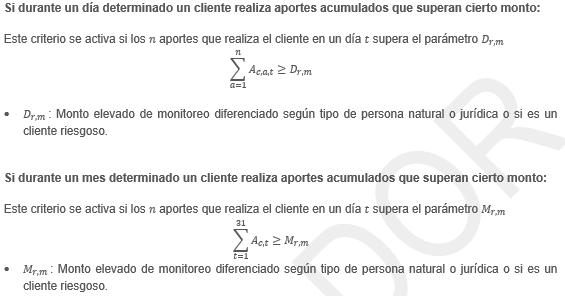

<!-- Tabla D -->
<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>D</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>25,000,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td></td>
            <td>100,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td></td>
            <td>300,000,000</td>
        </tr>
    </tbody>
</table>

<!-- Tabla M -->
<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>M</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>75,000,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td></td>
            <td>200,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td></td>
            <td>500,000,000</td>
        </tr>
    </tbody>
</table>


In [33]:
# AGRUPAR OPERACIONES POR DÍA Y MONTO PARA FILTRAR EL MONTO MÍNIMO DE OPERACIÓN
df_diario_A = df_combinado_A.groupby(['IDENTIFICADOR', 'FECHA_MOVIMIENTO']).agg(
    total_monto_diario=('MONTO_CLP', 'sum')
).reset_index()

df_diario_A['MES'] = df_diario_A['FECHA_MOVIMIENTO'].dt.to_period('M')
# AGRUPAR MENSUALMENTE
df_mensual_A = df_diario_A.groupby(['IDENTIFICADOR', 'MES']).agg(
    total_monto_mensual=('total_monto_diario', 'sum')
).reset_index()

# FUNCIÓN PARA ASIGNAR MONTOS SEGÚN SEGMENTO (DIARIO)
def asignar_adiario(row):
    if row['TIPO_PER'] == 'NATURAL':
        return 25_000_000 if row['RIESGO'] == 'ALTO' else 75_000_000
    return 250_000_000 if row['TIPO_PER'] == 'JURIDICA' else None

# FUNCIÓN PARA ASIGNAR MONTOS SEGÚN SEGMENTO (MENSUAL)
def asignar_amensual(row):
    if row['TIPO_PER'] == 'NATURAL':
        return 75_000_000 if row['RIESGO'] == 'ALTO' else 200_000_000
    return 500_000_000 if row['TIPO_PER'] == 'JURIDICA' else None

# MERGE DATOS ADICIONALES
df_diario_A = df_diario_A.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO', 'NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna(' ')
df_diario_A['M_diario'] = df_diario_A.apply(asignar_adiario, axis=1)

# PRIMER DÍA
primer_dia = df_diario_A.groupby('IDENTIFICADOR')['FECHA_MOVIMIENTO'].min().reset_index()
primer_dia.columns = ['IDENTIFICADOR', 'primer_dia']

# FILTRAR DISTINTAS PRIMER DÍA
df_diario_A = df_diario_A.merge(primer_dia, on='IDENTIFICADOR', how='left')
df_diario_A_sin_primer_dia = df_diario_A[df_diario_A['FECHA_MOVIMIENTO'] != df_diario_A['primer_dia']]

Señal_Aporte_Diario_Grande = df_diario_A_sin_primer_dia[
    df_diario_A_sin_primer_dia['total_monto_diario'] >= df_diario_A_sin_primer_dia['M_diario']
]


In [34]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Aporte_Diario_Grande['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Aporte_Diario_Grande['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Aporte_Diario_Grande.shape[0]}\n",
      Señal_Aporte_Diario_Grande.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 79 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.29 % 
Cantidad de veces que se levanta la señal: 1022
 MES
2023-01    40
2023-02    41
2023-03    55
2023-04    57
2023-05    47
2023-06    32
2023-07    21
2023-08    14
2023-09     7
2023-10    40
2023-11    49
2023-12    51
2024-01    55
2024-02    62
2024-03    60
2024-04    62
2024-05    63
2024-06    53
2024-07    64
2024-08    67
2024-09    37
2024-10    45
Freq: M, Name: count, dtype: int64


In [35]:
Señal_Aporte_Diario_Grande

,IDENTIFICADOR,FECHA_MOVIMIENTO,total_monto_diario,MES,TIPO_PER,RIESGO,NOMBRE_CLIENTE,M_diario,primer_dia
224,10092804-3,2024-02-28,"98,079,775",2024-02,NATURAL,,Boris Alarcon Tuna,75000000,2024-01-10
1318,10715052-8,2024-07-26,"200,000,000",2024-07,NATURAL,,Fidel Toro Mendoza,75000000,2024-01-17
3090,12653782-4,2024-09-05,"87,750,000",2024-09,NATURAL,,Rodrigo Antonio Magaña Muñoz,75000000,2024-09-03
3545,12912156-4,2024-06-10,"110,000,000",2024-06,NATURAL,,Maria Lorena Alcantara Martinez,75000000,2024-01-04
5327,13671481-3,2023-07-06,"86,000,000",2023-07,NATURAL,,SEBASTIAN PILASI MENICHETTI,75000000,2023-01-12
5334,13671481-3,2024-02-07,"86,500,000",2024-02,NATURAL,,SEBASTIAN PILASI MENICHETTI,75000000,2023-01-12
5825,13882822-0,2023-07-13,"100,000,000",2023-07,NATURAL,,JUAN PABLO UGARTE AMENABAR,75000000,2023-02-10
5827,13882822-0,2024-02-01,"150,000,000",2024-02,NATURAL,,JUAN PABLO UGARTE AMENABAR,75000000,2023-02-10
5828,13882822-0,2024-02-05,"150,000,000",2024-02,NATURAL,,JUAN PABLO UGARTE AMENABAR,75000000,2023-02-10
5829,13882822-0,2024-06-14,"100,000,000",2024-06,NATURAL,,JUAN PABLO UGARTE AMENABAR,75000000,2023-02-10


#### 5.2 APORTES DURANTE UN MES ELEVADO

In [36]:
df_mensual_A = df_diario_A.groupby(['IDENTIFICADOR', 'MES']).agg(
    total_monto_mensual=('total_monto_diario', 'sum'),
    dias_aportes=('FECHA_MOVIMIENTO', 'nunique')  # Cuenta días únicos de aportes
).reset_index()



df_mensual_A = df_mensual_A.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER','RIESGO','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna(' ')
df_mensual_A['M_mensual'] = df_mensual_A.apply(asignar_amensual, axis=1)
Señal_Aporte_Mensual_Grande = df_mensual_A[(df_mensual_A['total_monto_mensual'] >= df_mensual_A['M_mensual']) & (df_mensual_A['dias_aportes'] >= 2)]

In [37]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Aporte_Mensual_Grande['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Aporte_Mensual_Grande['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Aporte_Mensual_Grande.shape[0]}\n",
      Señal_Aporte_Mensual_Grande.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 39 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.14 % 
Cantidad de veces que se levanta la señal: 187
 MES
2023-01     4
2023-02     5
2023-03     8
2023-04     7
2023-05     4
2023-06     5
2023-07     5
2023-08     4
2023-09     3
2023-10     9
2023-11     6
2023-12     9
2024-01    10
2024-02    10
2024-03    13
2024-04    11
2024-05    14
2024-06    14
2024-07    12
2024-08    11
2024-09    10
2024-10    13
Freq: M, Name: count, dtype: int64


#### 6. INCREMENTO EN LA FRECUENCIA DE APORTES

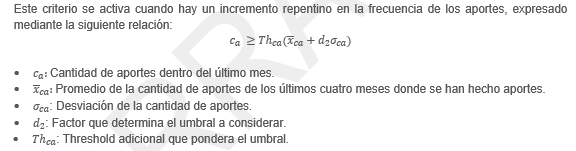

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripcion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>n_meses</td>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
    <tr>
      <td>d_2</td>
      <td>3</td>
      <td>Cantidad de desviación estándar para el umbral</td>
    </tr>
    <tr>
      <td>cant_min_aportes</td>
      <td>5</td>
      <td>Cantidad mínima del aportes para el criterio</td>
    </tr>
    <tr>
      <td>TH</td>
      <td>1,3</td>
      <td>Threshold para robustecer el umbral</td>
    </tr>
  </tbody>
</table>


In [38]:
# PARAMETRO UMBRAL Y CANTIDAD DE MESES A CONSIDERAR
n_meses = 4 
d_2 = 3
cant_min_aportes = 5
TH = 1.3

In [39]:
alertas_frecuencia_A = []
# ITERAR POR CADA IDENTIFICADOR
for id_cliente in df_grouped_A['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_A[df_grouped_A['IDENTIFICADOR'] == id_cliente]
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES')
    
    # COMENZAR DESDE EL n_meses, YA QUE SE REQUIEREN LOS n_meses ANTERIORES
    for i in range(n_meses, len(df_cliente)):
        # SELECCIONAR LOS ÚLTIMOS n_meses DONDE HUBO APORTES
        ultimos_n_meses = df_cliente.iloc[i-n_meses:i]
        
        # FILTRAR APORTES VÁLIDOS
        ultimos_n_meses_validos = ultimos_n_meses[ultimos_n_meses['count_aportes'] > 0]
        
        if len(ultimos_n_meses_validos) < 1:
            continue  # PASA AL SIGUIENTE CLIENTE SI NO HAY DATOS VÁLIDOS
        
        # PROMEDIO Y DESVIACIÓN ESTÁNDAR DE APORTES
        promedio_aportes = ultimos_n_meses_validos['count_aportes'].mean()
        std_aportes = ultimos_n_meses_validos['count_aportes'].std()
        
        # CANTIDAD DE APORTES EN EL MES ACTUAL
        aportes_actual = df_cliente.iloc[i]['count_aportes']
        
        # CONDICIÓN DE UMBRAL FRECUENCIA DE APORTES: c_a ≥ x_ca + d_2 * σ_ca
        if aportes_actual > cant_min_aportes and aportes_actual > TH * (promedio_aportes + d_2 * std_aportes):
            alertas_frecuencia_A.append({
                'MES': df_cliente.iloc[i]['MES'],
                'IDENTIFICADOR': id_cliente,
                'aportes_actual': aportes_actual,
                'promedio_aportes': promedio_aportes,
                'std_aportes': std_aportes,
                'umbral': TH * (promedio_aportes + d_2 * std_aportes)
            })

# Crear DataFrame con las alertas
df_alerta_FRECUENCIAAPORTES = pd.DataFrame(alertas_frecuencia_A)

In [40]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_FRECUENCIAAPORTES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_FRECUENCIAAPORTES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_FRECUENCIAAPORTES.shape[0]}\n",
      df_alerta_FRECUENCIAAPORTES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 129 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.47 % 
Cantidad de veces que se levanta la señal: 134
 MES
2023-05     1
2023-06     2
2023-07     3
2023-08     4
2023-09     2
2023-10     3
2023-11     7
2023-12     2
2024-01    10
2024-02     9
2024-03    12
2024-04    14
2024-05     7
2024-06     8
2024-07    12
2024-08    15
2024-09     9
2024-10    14
Freq: M, Name: count, dtype: int64


In [41]:
df_alerta_FRECUENCIAAPORTES = pd.merge(df_alerta_FRECUENCIAAPORTES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

#### 7. CLIENTE APORTA Y TIENE EL DINERO INMOVILIZADO

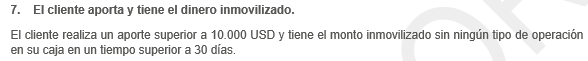

In [42]:
monto_inmovilizado = 10_000_000

In [43]:
df_saldo_caja['FECHA_CIERRE'] = pd.to_datetime(df_saldo_caja['FECHA_CIERRE'])
df_saldo_caja['MES'] = df_saldo_caja['FECHA_CIERRE'].dt.to_period('M') 
df_saldo_caja_2 = df_saldo_caja[df_saldo_caja['MONTO_EN_PESOS'] > monto_inmovilizado]
df_saldo_caja_2 = df_saldo_caja_2.sort_values(['IDENTIFICADOR', 'TIPO_CAJA', 'FECHA_CIERRE'])
df_saldo_caja_2['MES'] = df_saldo_caja_2['FECHA_CIERRE'].dt.to_period('M') 

def find_same_monto_consecutive_months(group):
    group['year_month_diff'] = (
        (group['FECHA_CIERRE'].dt.year - group['FECHA_CIERRE'].dt.year.shift(1)) * 12 +
        (group['FECHA_CIERRE'].dt.month - group['FECHA_CIERRE'].dt.month.shift(1))
    )
    
    group['same_monto_consecutive'] = (group['year_month_diff'] == 1) & (group['MONTO_MON_CAJA'] == group['MONTO_MON_CAJA'].shift(1))
    

    return group[group['same_monto_consecutive']]

result_df = df_saldo_caja_2.groupby(['IDENTIFICADOR', 'TIPO_CAJA']).apply(find_same_monto_consecutive_months).reset_index(drop=True)

#### restante ###
df_monto_inmovilizado = result_df.copy()

if not df_monto_inmovilizado.empty:
    del df_monto_inmovilizado['ESTADO']
    del df_monto_inmovilizado['year_month_diff']
    del df_monto_inmovilizado['same_monto_consecutive']
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M')  

In [44]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_monto_inmovilizado['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_monto_inmovilizado['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_monto_inmovilizado.shape[0]}\n",
      df_monto_inmovilizado.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 37 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.14 % 
Cantidad de veces que se levanta la señal: 99
 MES
2024-02     9
2024-03     7
2024-04    10
2024-05     7
2024-06     8
2024-07    11
2024-08    15
2024-09    12
2024-10    11
2024-11     9
Freq: M, Name: count, dtype: int64


In [45]:
df_operaciones.loc[df_operaciones['COD_MONEDA_OP'] == 'CLP', 'TIPO_CAJA'] = 'CAJA PESOS'
df_operaciones.loc[df_operaciones['COD_MONEDA_OP'] == 'USD', 'TIPO_CAJA'] = 'CAJA DOLAR'

In [46]:
# checkear si no hay operaciones en ese periodo
def check_operations(row, df_operaciones):
    ID1 = row['IDENTIFICADOR']
    NUM_CUENTA1 = row['NUM_CUENTA']
    TIPO_CAJA1 = row['TIPO_CAJA']
    FECHA_CIERRE1 = pd.to_datetime(row['FECHA_CIERRE'])

    # condiciones
    c1 = df_operaciones['IDENTIFICADOR'] == ID1
    c2 = df_operaciones['NUM_CUENTA'] == NUM_CUENTA1
    c3 = df_operaciones['TIPO_CAJA'] == TIPO_CAJA1
    c4 = (df_operaciones['FECHA_OPERACION'] >= (FECHA_CIERRE1 - pd.DateOffset(months=1))) & (df_operaciones['FECHA_OPERACION'] <= FECHA_CIERRE1)

    filtered_df = df_operaciones[c1 & c2 & c3 & c4]
    return filtered_df.empty

df_monto_inmovilizado['is_empty'] = df_monto_inmovilizado.apply(check_operations, axis=1, df_operaciones=df_operaciones)
df_monto_inmovilizado

,Unnamed: 0,NOMBRE_ASESOR,IDENTIFICADOR,NUM_CUENTA,NOMBRE_CLI,FECHA_CIERRE,TIPO_CAJA,MONTO_MON_CAJA,MONTO_EN_PESOS,TRANSITO,MES,is_empty
0,10232,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-02-01,CAJA DOLAR,"34,723",32371003,0,2024-02,True
1,10233,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-03-01,CAJA DOLAR,"34,723",33678329,0,2024-03,True
2,10234,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-04-01,CAJA DOLAR,"34,723",34088062,0,2024-04,True
3,10235,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-05-01,CAJA DOLAR,"34,723",33134565,0,2024-05,True
4,10236,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-06-01,CAJA DOLAR,"34,723",31833141,0,2024-06,True
5,10237,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-07-01,CAJA DOLAR,"34,723",32790458,0,2024-07,True
6,10238,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-08-01,CAJA DOLAR,"34,723",32771013,0,2024-08,True
7,10239,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-09-01,CAJA DOLAR,"34,723",31736611,0,2024-09,True
8,10240,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-10-01,CAJA DOLAR,"34,723",31170276,0,2024-10,True
9,10241,MESA ATENCIÓN AL INVERSIONISTA II .,10282332-K,10282332/0,CRISTIAN ALBERTO DE LA CARRERA LANTADILLA,2024-11-01,CAJA DOLAR,"34,723",33379016,0,2024-11,True


In [47]:
df_monto_inmovilizado = pd.merge(df_monto_inmovilizado, df_muestra2[['IDENTIFICADOR','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

In [48]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {result_df['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * result_df['IDENTIFICADOR'].nunique() / m, 2)} %")

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 37 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.14 %


### CRITERIO RETIROS

**SUB DF DE RESCATES A MONITOREAR:**
De todos los rescates disponibles se toma una porción de los rescates dados los parámetros $\alpha$ y $\beta$,
se arma estadística del promedio, desviación estándar de los rescates.

In [49]:
Rescates = df_APORET_detalle[df_APORET_detalle["CARGO_ABONO"] == 'C']
df_Rescates_copia = Rescates.copy()
df_Rescates_copia['FECHA_MOVIMIENTO'] = pd.to_datetime(df_Rescates_copia['FECHA_MOVIMIENTO'])  
df_Rescates_copia['MES'] = df_Rescates_copia['FECHA_MOVIMIENTO'].dt.to_period('M') 

# MERGE CON DF_MUESTRA2 PARA OBTENER 'TIPO_PER' Y 'RIESGO' ASOCIADOS AL 'IDENTIFICADOR'
df_Rescates_copia = df_Rescates_copia.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left')

# CREA COLUMNAS ALPHA Y BETA
df_Rescates_copia[['Alpha', 'Beta']] = df_Rescates_copia.apply(asignar_limites, axis=1, result_type='expand')
# FILTRAR APORTES MAYORES A ALPHA
df_Rescates_copia_filtrado = df_Rescates_copia[df_Rescates_copia['MONTO_CLP'] >= df_Rescates_copia['Alpha']]

# RESUMEN POR CLIENTE Y MES, SUMANDO LOS MONTOS
df_resumen_R = df_Rescates_copia.groupby(['IDENTIFICADOR', 'MES'])['MONTO_CLP'].sum().reset_index()
# IDENTIFICAR LOS MESES DONDE EL TOTAL SUPERA BETA
meses_superan_Beta_R = df_resumen_R.merge(df_Rescates_copia[['IDENTIFICADOR', 'MES', 'Beta']].drop_duplicates(),
                                          on=['IDENTIFICADOR', 'MES'])
meses_superan_Beta_R = meses_superan_Beta_R[meses_superan_Beta_R['MONTO_CLP'] >= meses_superan_Beta_R['Beta']][['IDENTIFICADOR', 'MES']]
df_Rescates_copia_superan_Beta = df_Rescates_copia.merge(meses_superan_Beta_R, on=['IDENTIFICADOR', 'MES'])

# DF COMBINADO
df_combinado_R = pd.concat([df_Rescates_copia_filtrado, df_Rescates_copia_superan_Beta]).drop_duplicates()
df_combinado_R['MES_NUM'] = df_combinado_R['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)

<table>
  <thead>
    <tr>
      <th>Nm_R</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de rescates</td>
    </tr>
  </tbody>
</table>


In [50]:
# PARAMETROS ESTADÍSTICA
Nm_R = 4

# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_combinado_R = df_combinado_R.sort_values(by=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'])
df_combinado_R['MES_NUM2'] = (df_combinado_R.groupby('IDENTIFICADOR')['MES_NUM']
                             .rank(method='dense').astype(int))
# SELECCIONA LOS N MESES ANTERIORES
resultados = []
for identificador, grupo in df_combinado_R.groupby('IDENTIFICADOR'):
    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        # FILTRAR LAS FILAS DE N MESES ANTERIORES
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_R)]
        
        promedio_rescates = ultimos_n_meses['MONTO_CLP'].mean()
        std_rescates = ultimos_n_meses['MONTO_CLP'].std()
        
        # AGREGA RESUTLADO AL DF
        resultados.append({
            'IDENTIFICADOR': identificador,
            'MES': mes_actual,
            'promedio_rescates': promedio_rescates,
            'std_rescates': std_rescates
        })

df_resultados_R = pd.DataFrame(resultados)
df_resultados_R = df_resultados_R.drop_duplicates(subset=['IDENTIFICADOR','MES'])

for identifier in df_resultados_R['IDENTIFICADOR'].unique():
    ## INDICES N/A
    indices = df_resultados_R[df_resultados_R['IDENTIFICADOR'] == identifier].index[:Nm_R]
    df_resultados_R.loc[indices, ['promedio_rescates', 'std_rescates']] = 'n/a'

df_grouped_R = df_resultados_R.copy()
df_grouped_R['promedio_rescates'] = pd.to_numeric(df_grouped_R['promedio_rescates'], errors='coerce')
df_grouped_R['std_rescates'] = pd.to_numeric(df_grouped_R['std_rescates'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\2217275593.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'n/a' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados_R.loc[indices, ['promedio_rescates', 'std_rescates']] = 'n/a'


#### 1. CRITERIO RETIROS SIMILARES EN MONTOS

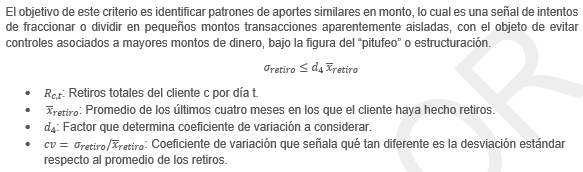

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>cant_minima_retiros</td>
      <td>5</td>
      <td>Cantidad mínima de retiros para evitar aplicar el criterio en rescates insuficientes</td>
    </tr>
    <tr>
      <td>$d_{3}$</td>
      <td>0.1</td>
      <td>Coeficiente de variación que relaciona que tan distinto es el promedio respecto a la desviación estándar para identificar rescates similares</td>
    </tr>
  </tbody>
</table>


In [51]:
cant_minima_retiros = 5
d_3 = 0.1

## COEFICIENTE DE VARIACION
df_grouped_R = df_combinado_R.groupby(['MES', 'IDENTIFICADOR']).agg(
    promedio_rescates=('MONTO_CLP', 'mean'),
    std_rescates=('MONTO_CLP', 'std'),
    count_rescates=('MONTO_CLP', 'size')
).reset_index()

df_grouped_R['coef_var'] = df_grouped_R['std_rescates'] / df_grouped_R['promedio_rescates']
df_grouped_R['alerta'] = (df_grouped_R['coef_var'] <= d_3) & (df_grouped_R['count_rescates'] >= cant_minima_retiros)

# FILTRA LOS DE LA ALERTA
df_alerta_RETIROSSIMILARES = df_grouped_R[df_grouped_R['alerta']]
df_alerta_RETIROSSIMILARES = df_alerta_RETIROSSIMILARES.reset_index(drop=True)

In [52]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_RETIROSSIMILARES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_RETIROSSIMILARES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_RETIROSSIMILARES.shape[0]}\n",
      df_alerta_RETIROSSIMILARES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 50 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.18 % 
Cantidad de veces que se levanta la señal: 58
 MES
2023-01    2
2023-04    1
2023-05    2
2023-06    2
2023-07    3
2023-09    1
2023-11    2
2023-12    1
2024-01    4
2024-02    1
2024-03    3
2024-04    3
2024-05    4
2024-06    3
2024-07    8
2024-08    6
2024-09    5
2024-10    7
Freq: M, Name: count, dtype: int64


In [53]:
df_alerta_RETIROSSIMILARES = pd.merge(df_alerta_RETIROSSIMILARES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

#### 2. INCREMENTO EN LA FRECUENCIA DE RETIROS

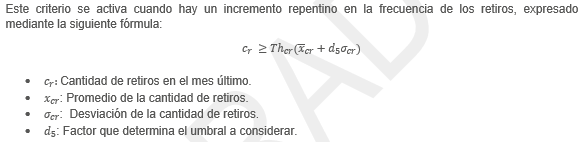

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripcion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>n_meses</td>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
    <tr>
      <td>$d_{4}$</td>
      <td>3</td>
      <td>Cantidad de desviación estándar para el umbral</td>
    </tr>
    <tr>
      <td>cant_min_rescates</td>
      <td>5</td>
      <td>Cantidad mínima de rescates para el criterio</td>
    </tr>
    <tr>
      <td>$TH_{R}$</td>
      <td>1,3</td>
      <td>Threshold para robustecer el umbral</td>
    </tr>
  </tbody>
</table>


In [54]:
# PARAMETRO UMBRAL Y CANTIDAD DE MESES A CONSIDERAR
n_meses = 4 
d_4 = 3
cant_min_rescates = 5
TH_R = 1.2

In [55]:
alertas_frecuencia_R = []
# ITERAR POR CADA IDENTIFICADOR
for id_cliente in df_grouped_R['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_R[df_grouped_R['IDENTIFICADOR'] == id_cliente]
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES')
    
    # COMENZAR DESDE EL MES n_meses
    for i in range(n_meses, len(df_cliente)):
        # SELECCIONAR LOS ÚLTIMOS n_meses
        ultimos_n_meses = df_cliente.iloc[i-n_meses:i]
        
        # FILTRAR RESCATES VÁLIDOS
        ultimos_n_meses_validos = ultimos_n_meses[ultimos_n_meses['count_rescates'] > 0]
        
        if len(ultimos_n_meses_validos) < 1:
            continue  # PASAR AL SIGUIENTE CLIENTE SI NO HAY DATOS VÁLIDOS
        
        # CALCULAR PROMEDIO Y DESVIACIÓN ESTÁNDAR DE RESCATES
        promedio_rescate = ultimos_n_meses_validos['count_rescates'].mean()
        std_rescate = ultimos_n_meses_validos['count_rescates'].std()
        
        # OBTENER CANTIDAD DE RESCATES DEL MES ACTUAL
        rescates_actual = df_cliente.iloc[i]['count_rescates']
        
        # ESTABLECER CONDICIÓN c_a ≥ x_ca + d_4 * σ_ca
        if rescates_actual > cant_min_rescates and rescates_actual > TH_R * (promedio_rescate + d_4 * std_rescate):
            alertas_frecuencia_R.append({
                'MES': df_cliente.iloc[i]['MES'],
                'IDENTIFICADOR': id_cliente,
                'rescates_actual': rescates_actual,
                'promedio_rescate': promedio_rescate,
                'std_rescate': std_rescate,
                'umbral': promedio_rescate + d_4 * std_rescate
            })

# CREAR DATAFRAME CON LAS ALERTAS
df_alerta_FRECUENCIARETIROS = pd.DataFrame(alertas_frecuencia_R)

In [56]:
df_alerta_FRECUENCIARETIROS = pd.merge(df_alerta_FRECUENCIARETIROS, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

In [57]:
df_alerta_FRECUENCIARETIROS

,MES,IDENTIFICADOR,rescates_actual,promedio_rescate,std_rescate,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2023-12,12859545-7,6,2,1,3,RODRIGO ANDRES VELOSO ROBLES,NATURAL,
1,2023-05,13171843-8,12,2,1,6,Carlos Andrés Arriagada Carrazana,NATURAL,
2,2024-04,14688827-5,7,2,1,5,Martin Tage Muler,NATURAL,
3,2023-08,15495357-4,10,1,0,3,Miguel Angel Inostroza Lerdón,NATURAL,
4,2024-02,16017822-1,6,2,0,3,JOSE GASPAR DE LA CARRERA GARRIDO,NATURAL,
5,2024-07,16891839-9,14,2,2,8,Fernando Roberto Cortés Rivera,NATURAL,
6,2024-02,17265026-0,26,3,2,8,Nicolás Claudio García Soto,NATURAL,
7,2024-05,17669780-6,7,2,1,4,Mario Portilla Espinoza,NATURAL,
8,2024-05,24858151-4,6,2,1,5,Camilo Ernesto Cabrera Camacho,NATURAL,
9,2023-10,76415528-9,20,2,2,8,BUDA.COM SPA,JURIDICA,ALTO


In [58]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_FRECUENCIARETIROS.shape[0]}\n",
      df_alerta_FRECUENCIARETIROS.value_counts('MES').sort_index())

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 88 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.32 % 
Cantidad de veces que se levanta la señal: 91
 MES
2023-05     1
2023-08     2
2023-10     3
2023-11     1
2023-12     3
2024-01     9
2024-02     5
2024-03     5
2024-04     6
2024-05    10
2024-06     2
2024-07     6
2024-08    14
2024-09     5
2024-10    19
Freq: M, Name: count, dtype: int64


## CRITERIO OPERACIONES

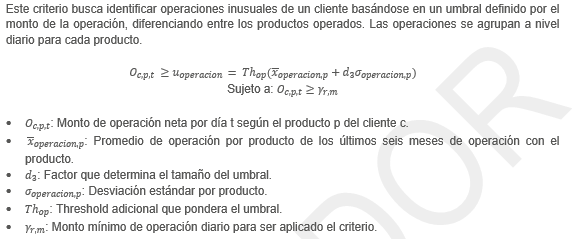

<!-- Tabla O -->
<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>O</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>500,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td></td>
            <td>1,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td></td>
            <td>5,000,000</td>
        </tr>
    </tbody>
</table>


In [59]:
def asignar_O(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'ALTO':
            return 500_000
        else:
            return 1_000_000
    if row['TIPO_PER'] == 'JURIDICA':
        return 5_000_000


df_operaciones['COD_TIPO_OPERACION'].value_counts()

cod_tipo_op = ['FWDV'
'FWDC',
'COMPRA_OTC',
'VENTA',   
'VIFM',
'CIRVS',
'VIRVS',
'CIFM',
'COMPRA',
'VIRV',
'CIRV']     

In [60]:
df_operaciones.sample(2)

,NUM_CUENTA,IDENTIFICADOR,NOMBRE_CLIENTE,NOMBRE_ASESOR,FECHA_OPERACION,COD_TIPO_OPERACION,DSC_OPERACION_CONCEPTO,COD_MONEDA_OP,NEMOTECNICO,DSC_INSTRUMENTO,COD_SUB_CLASE_INSTRUMENTO,CANTIDAD,MONTO,MONTO_OPERACION,DOLAR_OBS,MONTO_CLP,TIPO_CAJA
736004,14165572/60,14165572-8,Cristian Cubillos Román,RACIONAL .,2024-04-11,CIFM,COMPRA FONDOS CB,CLP,CFIETFCD,FI ETF SINGULAR CHILE CORTA DURACION,CFI,"4,092","4,973,744","4,973,744",954,"4,973,744",CAJA PESOS
455496,20596951/60,20596951-9,Andres De Jesus Pincheira Villalobos,RACIONAL .,2024-03-06,COMPRA,COMPRA SPOT,CLP,USD,USD,SPOT_NAC,30,"30,000","30,000",976,"30,000",CAJA PESOS


In [61]:
df_operaciones = df_operaciones.copy()
df_operaciones['MES'] = df_operaciones['FECHA_OPERACION'].dt.to_period('M') 
df_operaciones = df_operaciones[df_operaciones['COD_TIPO_OPERACION'].isin(cod_tipo_op)]
# AGRUPAR OPERACIONES POR DIA Y MONTO PARA FILTRAR EL MONTO MINIMO DE OPERACION
df_diario = df_operaciones.groupby(['IDENTIFICADOR', 'FECHA_OPERACION', 'COD_SUB_CLASE_INSTRUMENTO']).agg(
    total_monto_diario=('MONTO_CLP', 'sum')
).reset_index()

In [62]:
df_diario = df_diario.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')
df_diario['monto_min_monitoreo'] = df_diario.apply(asignar_O, axis=1, result_type='expand')

# FILTRADO
df_filtrado = df_diario[df_diario['total_monto_diario'] >= df_diario['monto_min_monitoreo']].copy()
df_filtrado['FECHA_OPERACION'] = pd.to_datetime(df_filtrado['FECHA_OPERACION'])  
df_filtrado['MES'] = df_filtrado['FECHA_OPERACION'].dt.to_period('M') 

df_filtrado['MES_NUM'] = df_filtrado['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)
df_filtrado['MES_NUM'] = df_filtrado['MES_NUM'] - df_filtrado['MES_NUM'].min() + 1

# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_filtrado = df_filtrado.sort_values(by=['IDENTIFICADOR', 'FECHA_OPERACION'])
df_filtrado['MES_NUM2'] = df_filtrado.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO', 'MES']).ngroup() + 1

**PARAMETROS ESTADÍSTICA Y UMBRAL**

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Nm_O</td>
      <td>4</td>
      <td>Número meses de datos de aportes para el umbral</td>
    </tr>
    <tr>
      <td>$d_5$</td>
      <td>3.5</td>
      <td>Cantidad de std</td>
    </tr>
    <tr>
      <td>$th_o$</td>
      <td>1.5</td>
      <td>Threshold en caso de que la std sea nula para hacer más robusto el umbral</td>
    </tr>
    <tr>
      <td>$th_{nstd}$</td>
      <td>1.5</td>
      <td>Threshold adicional al umbral, lo hace más conservador en caso de que la std sea baja y así el umbral es más robusto</td>
    </tr>
  </tbody>
</table>

In [63]:
# PARÁMETRO PARA EL UMBRAL Y NÚMERO DE MESES
d_5 = 3.5
Nm_O = 4
th_o_N = 1.5
th_o_J = 2

In [64]:
resultados = []
# AGRUPAR por IDENTIFICADOR, COD_SUB_CLASE_INSTRUMENTO
for (identificador, cod_instrumento), grupo in df_filtrado.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    
    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        
        # FILTRAR ULTIMOS Nm_O
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_O)]
        
        # ESTADÍSTICA
        promedio_operacion = ultimos_n_meses['total_monto_diario'].mean()
        std_operacion = ultimos_n_meses['total_monto_diario'].std()
        
        resultados.append({
            'IDENTIFICADOR': identificador,
            'COD_SUB_CLASE_INSTRUMENTO': cod_instrumento,
            'MES': mes_actual,
            'promedio_operacion': promedio_operacion,
            'std_operacion': std_operacion
        })


df_resultados_O = pd.DataFrame(resultados)
df_resultados_O = df_resultados_O.drop_duplicates(subset=['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO', 'MES'])

# PRIMEROS N MESES, 'promedio_operacion'  'std_operacion' a 'NaN' para cada IDENTIFICADOR y COD_SUB_CLASE_INSTRUMENTO
for (identificador, cod_instrumento), grupo in df_resultados_O.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    indices = grupo.index[:Nm_O]
    df_resultados_O.loc[indices, ['promedio_operacion', 'std_operacion']] = 'NaN'

# CONVERTIR A NUMÉRICO PARA ERRORES
df_grouped_O = df_resultados_O.copy()
df_grouped_O['promedio_operacion'] = pd.to_numeric(df_grouped_O['promedio_operacion'], errors='coerce')
df_grouped_O['std_operacion'] = pd.to_numeric(df_grouped_O['std_operacion'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\143341883.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados_O.loc[indices, ['promedio_operacion', 'std_operacion']] = 'NaN'


**OBTENCIÓN UMBRAL**

In [65]:
df_grouped_O = pd.merge(df_grouped_O, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [66]:
alertas_operacion = []

# Agrupar por 'IDENTIFICADOR' y 'COD_SUB_CLASE_INSTRUMENTO'
for (id_cliente, cod_sub_clase), df_cliente in df_grouped_O.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES').reset_index(drop=True)

    # ITERAR DESDE Nm_O HASTA FINAL DF
    for i in range(Nm_O, len(df_cliente)):
        # MES ACTUAL Y DATOS CLIENTES
        mes_actual = df_cliente.iloc[i]['MES']
        
        # Conversión explícita de valores numéricos
        try:
            promedio_operacion = float(df_cliente.iloc[i]['promedio_operacion'])
            std_operacion = float(df_cliente.iloc[i]['std_operacion'])
            tipo_per = df_cliente.iloc[i]['TIPO_PER']  # 'TIPO_PER' no necesita conversión
        except ValueError as e:
            print(f"Error al convertir valores en fila {i} del cliente {id_cliente}: {e}")
            continue
        
        # APORTES MES ACTUAL
        operaciones_actuales_filtro = df_filtrado[
            (df_filtrado['MES'] == mes_actual) & 
            (df_filtrado['IDENTIFICADOR'] == id_cliente) & 
            (df_filtrado['COD_SUB_CLASE_INSTRUMENTO'] == cod_sub_clase)
        ]

        # ITERA SOBRE APORTES
        for _, operacion_fila in operaciones_actuales_filtro.iterrows():
            
            # Conversión explícita de los valores numéricos del aporte
            try:
                operacion_actual = float(operacion_fila['total_monto_diario'])
                fecha_operacion = operacion_fila['FECHA_OPERACION']  # No necesita conversión
            except ValueError as e:
                print(f"Error al convertir el monto o la fecha: {e}")
                continue
            
            # Conversión explícita de constantes (por seguridad)
            th_o_N = float(th_o_N)
            th_o_J = float(th_o_J)
            d_5 = float(d_5)

            # Cálculo del umbral
            if std_operacion == 0:
                umbral = promedio_operacion * th_nstd  # Threshold sin STD
            else:
                if tipo_per == 'NATURAL':
                    umbral = th_o_N * (promedio_operacion + d_5 * std_operacion)  # NATURAL
                elif tipo_per == 'JURIDICA':
                    umbral = th_o_J * (promedio_operacion + d_5 * std_operacion)  # JURIDICA
            
            # OBTIENE APORTES SOBRE UMBRAL
            if operacion_actual > umbral:
                alertas_operacion.append({
                    'MES': mes_actual,
                    'FECHA_OPERACION': fecha_operacion, 
                    'IDENTIFICADOR': id_cliente,
                    'COD_SUB_CLASE_INSTRUMENTO': cod_sub_clase,
                    'operacion_actual': operacion_actual,
                    'promedio_operacion': promedio_operacion,
                    'std_operacion': std_operacion,
                    'umbral': umbral
                })

# Crear DataFrame de alertas
df_alerta_OPERACIONSUPERAUMBRAL = pd.DataFrame(alertas_operacion)


In [67]:
df_alerta_OPERACIONSUPERAUMBRAL = df_alerta_OPERACIONSUPERAUMBRAL.rename(columns={"COD_SUB_CLASE_INSTRUMENTO": "Producto"})

In [68]:
df_alerta_OPERACIONSUPERAUMBRAL = pd.merge(df_alerta_OPERACIONSUPERAUMBRAL, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ') #debug

In [69]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_OPERACIONSUPERAUMBRAL.shape[0]}\n",
      df_alerta_OPERACIONSUPERAUMBRAL.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 27194  
Clientes con señal de alerta: 296 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 1.09 % 
Cantidad de veces que se levanta la señal: 436
 MES
2023-05    12
2023-06    16
2023-07    14
2023-08    16
2023-09    17
2023-10    24
2023-11    26
2023-12    16
2024-01    31
2024-02    34
2024-03    27
2024-04    34
2024-05    39
2024-06    32
2024-07    62
2024-08    28
2024-09     8
Freq: M, Name: count, dtype: int64


## CRITERIO PATRIMONIO

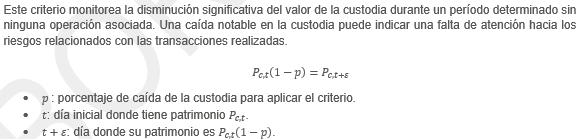

In [70]:
custodia_detalle_test = df_custodia_detalle.copy()
operaciones_consolidado_test = df_operaciones.copy()

# DATE TIME
custodia_detalle_test['fecha_cierre'] = pd.to_datetime(custodia_detalle_test['fecha_cierre'])
operaciones_consolidado_test['FECHA_OPERACION'] = pd.to_datetime(operaciones_consolidado_test['FECHA_OPERACION'])

# CAIDA VALOR
p = 7/100
pat_min = 4_000_000
caida_min = 1_000_000

# AÑO MES
custodia_detalle_test['MES'] = custodia_detalle_test['fecha_cierre'].dt.to_period('M')
operaciones_consolidado_test['MES'] = operaciones_consolidado_test['FECHA_OPERACION'].dt.to_period('M')

# CUSTODIA VALORIZADA DIARIA
suma_valor_diario = custodia_detalle_test.groupby(['IDENTIFICADOR', 'fecha_cierre']).agg(
    VALOR_MERCADO_DIA=('VALOR_MERCADO_CLP', 'sum')
).reset_index()

suma_valor_diario_minimo = suma_valor_diario[suma_valor_diario['VALOR_MERCADO_DIA'] > pat_min]

# OBTENER VALOR INICIO Y FIN DE MES
custodias_inicio_fin_mes = suma_valor_diario_minimo.groupby(['IDENTIFICADOR', suma_valor_diario_minimo['fecha_cierre'].dt.to_period('M')]).agg(
    VALOR_INICIO_MES=('VALOR_MERCADO_DIA', 'first'),
    VALOR_FIN_MES=('VALOR_MERCADO_DIA', 'last'),
    FECHA_INICIO=('fecha_cierre', 'first'),
    FECHA_FIN=('fecha_cierre', 'last')
).reset_index()

# Renombrar la columna de periodo a AÑO_MES para hacer el merge
custodias_inicio_fin_mes.rename(columns={'fecha_cierre': 'MES'}, inplace=True)

# MERGE CON OPERACIONES PARA OBTENER LAS OPERACIONES DENTRO DEL MISMO PERÍODO
custodias_con_operaciones = pd.merge(custodias_inicio_fin_mes, 
                                     operaciones_consolidado_test[['IDENTIFICADOR', 'MES', 'FECHA_OPERACION']],
                                     on=['IDENTIFICADOR', 'MES'], 
                                     how='left')

# CAIDA EN VALOR
custodias_con_operaciones['CAIDA_VALOR'] = (custodias_con_operaciones['VALOR_INICIO_MES'] - custodias_con_operaciones['VALOR_FIN_MES']) 
# FILTRAR CASOS DONDE LA CAÍDA DE VALOR SEA MAYOR O IGUAL AL 20% Y NO HAYA OPERACIONES EN ESE PERÍODO
resultados = custodias_con_operaciones[
    (custodias_con_operaciones['CAIDA_VALOR'] >= custodias_con_operaciones['VALOR_INICIO_MES']*p) &
    (custodias_con_operaciones['FECHA_OPERACION'].isna())
]


df_caida_significativa = resultados[['IDENTIFICADOR', 'VALOR_INICIO_MES', 'VALOR_FIN_MES', 'FECHA_INICIO', 'FECHA_FIN', 'CAIDA_VALOR']]
df_caida_significativa = df_caida_significativa[df_caida_significativa['CAIDA_VALOR'] > caida_min]

In [71]:
df_caida_significativa = pd.merge(df_caida_significativa, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')


# LOGICA  NIVELES DE ALERTA

In [72]:
df_caida_significativa['MES'] = df_caida_significativa['FECHA_INICIO'].dt.to_period('M')
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\17293857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')


In [73]:
peso_alertas = {
    2: ['Señal_Primer_Aporte_Grande_Alerta','Señal_Aporte_Diario_Grande', 'df_alerta_FRECUENCIARETIROS', 'df_aporte_mayor_custodia', 'df_alerta_APORTESIMILARES', 'Señal_Aporte_Mensual_Grande'], 
    3: ['df_alerta_FRECUENCIAAPORTES', 'df_caida_significativa', 'df_alerta_RETIROSSIMILARES'],
    5: ['df_alerta_APORTESUPERAUMBRAL', 'df_alerta_OPERACIONSUPERAUMBRAL', 'df_monto_inmovilizado'],
}

alert_map = {
    'df_alerta_APORTESUPERAUMBRAL': (df_alerta_APORTESUPERAUMBRAL, 'APORTE SUPERA UMBRAL'),
    'df_alerta_APORTESIMILARES': (df_alerta_APORTESIMILARES, 'APORTES SIMILARES'),
    'df_aporte_mayor_custodia': (df_aporte_mayor_custodia, 'APORTE MAYOR A CUSTODIA'),

    'Señal_Primer_Aporte_Grande_Alerta': (Señal_Aporte_Diario_Grande, 'PRIMER APORTE ELEVADO'),
    'Señal_Aporte_Diario_Grande': (Señal_Aporte_Diario_Grande, 'APORTES DIARIO ELEVADO'),
    'Señal_Aporte_Mensual_Grande': (Señal_Aporte_Mensual_Grande, 'APORTES MENSUAL ELEVADO'),

    'df_monto_inmovilizado': (df_monto_inmovilizado, 'APORTE INMOVILIZADO'),
    
    'df_alerta_FRECUENCIAAPORTES': (df_alerta_FRECUENCIAAPORTES, 'AUMENTO FRECUENCIA APORTES'),
    'df_alerta_RETIROSSIMILARES': (df_alerta_RETIROSSIMILARES, 'RETIROS SIMILARES'),
    'df_alerta_FRECUENCIARETIROS': (df_alerta_FRECUENCIARETIROS, 'AUMENTO FRECUENCIA RETIROS'),
    
    'df_alerta_OPERACIONSUPERAUMBRAL': (df_alerta_OPERACIONSUPERAUMBRAL, 'OPERACION SUPERA UMBRAL'),
    'df_caida_significativa': (df_caida_significativa, 'CAIDA SIGNIFICATIVA CUSTODIA')
}


results = []
for weight, alerts in peso_alertas.items():
    for alert in alerts:
        if alert in alert_map:
            dataframe, description = alert_map[alert]
            for index, row in dataframe.iterrows():
                results.append({
                    'IDENTIFICADOR': row['IDENTIFICADOR'],
                    'MES': row['MES'],
                    'SCORE': weight,
                    'DATAFRAME': description
                })

In [74]:
df_results = pd.DataFrame(results)
df_results_METODO1 = pd.pivot_table(df_results, values='SCORE', index=['IDENTIFICADOR','DATAFRAME'],columns=['MES'], aggfunc='sum')
df_results_METODO1 = df_results_METODO1.reset_index()
df_results_METODO1 = df_results_METODO1.fillna(0)
df_results_METODO1 = df_results_METODO1.rename_axis(None, axis=1)

In [75]:
######### CREACION MESES ADICIONALES
df_results_METODO2 = df_results_METODO1.copy()

all_months = pd.date_range(start='2022-01', end='2024-11', freq='MS').strftime('%Y-%m').tolist()
df_results_METODO2 = df_results_METODO2.set_index(['IDENTIFICADOR', 'DATAFRAME'])

df_results_METODO2.columns = df_results_METODO2.columns.astype(str)

for month in all_months:
    if month not in df_results_METODO2.columns:
        df_results_METODO2[month] = 0.0

# Volver a organizar las columnas de meses en orden cronológico
months_columns = sorted([col for col in df_results_METODO2.columns if col not in ['IDENTIFICADOR', 'DATAFRAME']])
# Reindexar el DataFrame incluyendo las columnas en orden
df_results_METODO2 = df_results_METODO2.reindex(columns=months_columns)
# Resetear el índice para volver al formato original
df_results_METODO2 = df_results_METODO2.reset_index()


In [76]:
df_results = df_results_METODO2.copy()
months = df_results_METODO2.columns[2:]

for index, row in df_results_METODO2.iterrows():
    for i, month in enumerate(months[:-2]):
        if row[month] != 0:
            df_results.at[index, months[i+1]] += row[month]
            df_results.at[index, months[i+2]] += row[month]

In [77]:
df_results_METODO2_sum = df_results.groupby('IDENTIFICADOR').sum().reset_index()
del df_results_METODO2_sum['DATAFRAME']

In [78]:
resultados = []

# Combinar los DataFrames para obtener la información de riesgo de cada cliente
df_combinado = pd.merge(df_results_METODO2_sum, df_muestra2[['IDENTIFICADOR', 'RIESGO','TIPO_PER','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna('')

# NIVELES Y EVALUACIÓN
for index, row in df_combinado.iterrows():
    identificador = row['IDENTIFICADOR']
    riesgo = row['RIESGO']
    
    for mes in df_combinado.columns[1:-1]:  # Evitamos la columna RIESGO en las fechas
        puntaje = row[mes]
        puntaje = pd.to_numeric(puntaje, errors='coerce')
        
        # Flujo diferenciado basado en el riesgo
        if pd.notna(puntaje) and puntaje != 0:
            if riesgo in ['PEP', 'JUDICIAL', 'ALTO']:
                if puntaje >= 5:
                    estado = 'REVISION'
                else:
                    estado = 'MONITOREO' if 1 <= puntaje < 5 else 'HALLAZGO'
            else:
                # Para clientes sin riesgo específico (NaN)
                if 1 <= puntaje <= 4:
                    estado = 'HALLAZGO'
                elif 5 <= puntaje <= 9:
                    estado = 'MONITOREO'
                else:
                    estado = 'REVISION'
            
            resultados.append({
                'IDENTIFICADOR': identificador,
                'MES': mes,
                'PUNTAJE': puntaje,
                'ESTADO': estado,
                'RIESGO': riesgo
            })


df_resultados_estado = pd.DataFrame(resultados)

# Aplicar reglas adicionales para ajustar estados basados en secuencias de "HALLAZGO" o "MONITOREO"
for identificador, group in df_resultados_estado.groupby('IDENTIFICADOR'):
    group = group.reset_index(drop=True)
    
    for i in range(len(group) - 3):  # Aseguramos que haya al menos 4 registros consecutivos
        subset = group.iloc[i:i+4]  # Tomamos 4 filas consecutivas
        
        # Si todos los estados en este grupo son HALLAZGO o MONITOREO y la suma de los puntajes supera 26, cambiar a REVISION
        if subset['ESTADO'].isin(['HALLAZGO', 'MONITOREO']).all() and subset['PUNTAJE'].sum() > 26:
            df_resultados_estado.loc[(df_resultados_estado['IDENTIFICADOR'] == identificador) & 
                                     (df_resultados_estado['MES'] == subset.iloc[3]['MES']), 'ESTADO'] = 'REVISION'


In [79]:
############################### FILTRA REVISION PARA NO REPETIR ALERTA
rows_to_keep = []

# Iterar sobre cada grupo de IDENTIFICADOR
for identificador, group in df_resultados_estado.groupby('IDENTIFICADOR'):
    # Ordenar el grupo por MES
    group = group.sort_values(by='MES')
    # Iterar sobre las filas del grupo
    previous_row = None
    for index, row in group.iterrows():
        if row['ESTADO'] == 'REVISION':
            if previous_row is None or row['PUNTAJE'] != previous_row['PUNTAJE']:
                rows_to_keep.append(row)
            previous_row = row
        if row['ESTADO'] == 'MONITOREO': 
            rows_to_keep.append(row)
        if row['ESTADO'] == 'HALLAZGO': 
            rows_to_keep.append(row)

############################### FILTRA REVISION PARA NO REPETIR ALERTA
filtered_df = pd.DataFrame(rows_to_keep)
filtered_df = filtered_df.reset_index(drop=True)
df_filtered = filtered_df.copy()

In [80]:
df_filtered = pd.merge(df_filtered, df_muestra2[['IDENTIFICADOR','TIPO_PER','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna('')

# ANALISIS ALERTAS GENERADAS

In [81]:
df_rev_mon = df_filtered[(df_filtered['ESTADO'] == 'REVISION') | (df_resultados_estado['ESTADO'] == 'MONITOREO')]
df_filtrado_dof = df_rev_mon.drop_duplicates(subset=['IDENTIFICADOR'], keep='first').reset_index(drop=True)

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\3185496423.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rev_mon = df_filtered[(df_filtered['ESTADO'] == 'REVISION') | (df_resultados_estado['ESTADO'] == 'MONITOREO')]


In [82]:
c1 = df_filtrado_dof['ESTADO'] == 'REVISION'
c2 = df_filtrado_dof['ESTADO'] == 'MONITOREO'
df_analisis = df_filtrado_dof[c1|c2].sort_values(by='MES').reset_index(drop=True)

In [83]:
suma_valor_diario['MES'] = suma_valor_diario['fecha_cierre'].dt.to_period('M')

In [84]:
def obtener_maximos(cliente_id, mes):

    c1p = suma_valor_diario['MES'] == mes
    c2p = suma_valor_diario['IDENTIFICADOR'] == cliente_id
    
    #  (custodia)
    df_custodia = suma_valor_diario[c1p & c2p]
    if not df_custodia.empty:
        max_custodia = df_custodia.loc[df_custodia['VALOR_MERCADO_DIA'].idxmax()]
        valor_max_custodia = max_custodia['VALOR_MERCADO_DIA']
        fecha_max_custodia = max_custodia['fecha_cierre']
    else:
        valor_max_custodia = None
        fecha_max_custodia = None
    
    # (operación diaria)
    c1o = df_filtrado['IDENTIFICADOR'] == cliente_id
    df_operacion = df_filtrado[c1o]
    if not df_operacion.empty:
        max_operacion = df_operacion.loc[df_operacion['total_monto_diario'].idxmax()]
        valor_max_operacion = max_operacion['total_monto_diario']
        fecha_max_operacion = max_operacion['FECHA_OPERACION']
    else:
        valor_max_operacion = None
        fecha_max_operacion = None

    # (aporte diario)
    c1a = df_diario_A['IDENTIFICADOR'] == cliente_id
    df_aporte = df_diario_A[c1a]
    if not df_aporte.empty:
        max_aporte = df_aporte.loc[df_aporte['total_monto_diario'].idxmax()]
        valor_max_aporte = max_aporte['total_monto_diario']
        fecha_max_aporte = max_aporte['FECHA_MOVIMIENTO']
    else:
        valor_max_aporte = None
        fecha_max_aporte = None

    return {
        'max_pat': valor_max_custodia,
        'fecha_pat': fecha_max_custodia,
        'max_op': valor_max_operacion,
        'fecha_op': fecha_max_operacion,
        'max_ap': valor_max_aporte,
        'fecha_ap': fecha_max_aporte
    }

# almacenar los resultados
df_analisis['max_pat'] = None
df_analisis['fecha_pat'] = None
df_analisis['max_op'] = None
df_analisis['fecha_op'] = None
df_analisis['max_ap'] = None
df_analisis['fecha_ap'] = None

# Iterar sobre cada fila en df_analisis
for idx, row in df_analisis.iterrows():
    cliente_id = row['IDENTIFICADOR']
    mes = row['MES']
    
    maximos = obtener_maximos(cliente_id, mes)
    df_analisis.at[idx, 'max_pat'] = maximos['max_pat']
    df_analisis.at[idx, 'fecha_pat'] = maximos['fecha_pat']
    df_analisis.at[idx, 'max_op'] = maximos['max_op']
    df_analisis.at[idx, 'fecha_op'] = maximos['fecha_op']
    df_analisis.at[idx, 'max_ap'] = maximos['max_ap']
    df_analisis.at[idx, 'fecha_ap'] = maximos['fecha_ap']

In [85]:
def crear_columna_envio_dof(df):
    df['Envio DOF'] = df.apply(
        lambda row: (
            
            (row['TIPO_PER'] == 'NATURAL' and 
            ((row['max_pat'] or 0) > 40_000_000 or 
             (row['max_op'] or 0) > 15_000_000 or 
             (row['max_ap'] or 0) > 40_000_000)) or

            (row['TIPO_PER'] == 'NATURAL' and row['RIESGO'] == 'ALTO' and
            ((row['max_pat'] or 0) > 25_000_000 or 
             (row['max_op'] or 0) > 8_000_000 or 
             (row['max_ap'] or 0) > 25_000_000)) or

            (row['TIPO_PER'] == 'JURIDICA' and 
            ((row['max_pat'] or 0) > 200_000_000 or 
             (row['max_op'] or 0) > 100_000_000 or 
             (row['max_ap'] or 0) > 200_000_000))
        ),
        axis=1
    )
    return df

df_analisis = crear_columna_envio_dof(df_analisis)

#### CONTINUACION LÓGICA

In [86]:
### ESTADISTICA ALERTAS
revision = df_filtered[df_filtered['ESTADO'] == 'REVISION'].reset_index(drop=True)
monitoreo = df_filtered[df_filtered['ESTADO'] == 'MONITOREO'].reset_index(drop=True)
hallazgo = df_filtered[df_filtered['ESTADO'] == 'HALLAZGO'].reset_index(drop=True)


print(f"Cantidad de clientes con señales de alerta: {df_filtered['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes que se les asigna REVISIÓN: {revision['IDENTIFICADOR'].nunique()}  \n" +
      f"Clientes que se les asigna MONITOREO: {monitoreo['IDENTIFICADOR'].nunique()}  \n" +
      f"Clientes que se les asigna HALLAZGO: {hallazgo['IDENTIFICADOR'].nunique()}  \n" 
     
     )

Cantidad de clientes con señales de alerta: 1020  
Clientes que se les asigna REVISIÓN: 353  
Clientes que se les asigna MONITOREO: 469  
Clientes que se les asigna HALLAZGO: 411  



In [87]:
resultado = df_filtered.groupby(['MES', 'ESTADO']).size().reset_index(name='Count')
pivot_table = resultado.pivot_table(index='MES', columns='ESTADO', values='Count', fill_value=0)

In [88]:
df_filtered_color = df_filtered.copy()

def color_estado(val):
    colors = {
        'REVISION': 'color: red',
        'MONITOREO': 'color: orange',
        'HALLAZGO': 'color: green'
    }
    return colors.get(val, '')

df_filtered_color = df_filtered_color.style.format({
    'PUNTAJE': '{:.1f}'
}).applymap(color_estado, subset=['ESTADO'])
#df_filtered_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\745892264.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(color_estado, subset=['ESTADO'])


# INTERFAZ SEÑALES DE ALERTA 

In [89]:
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')
#df_caida_significativa['MES'] = df_caida_significativa['FECHA_INICIO'].dt.to_period('M')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_17016\2547055310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')


In [90]:
# EXTRAER INFO PERSONAL
info_personal_cols = ['NOMBRE_CLIENTE', 'FECHA_NACIMIENTO', 'IDENTIFICADOR', 'COD_PAIS', 'PROFESION', 'EMPLEADOR', 'CARGO']
df_info_personal = df_DATOS_clientes[info_personal_cols].drop_duplicates(subset='IDENTIFICADOR')

# EXTRAER DATOS DE CUENTAS
datos_cuentas_cols = ['IDENTIFICADOR','NUM_CUENTA', 'NOMBRE_ASESOR', 'DSC_CUENTA', 'ESTADO_CUENTA', 'COD_MONEDA', 'FECHA_OPERATIVA']
df_datos_cuentas = df_DATOS_clientes[datos_cuentas_cols]

In [91]:
for e in ['fecha_op','fecha_ap','fecha_pat']:
    df_analisis[e] = pd.to_datetime(df_analisis[e])
    df_analisis[e] = df_analisis[e].dt.strftime('%Y-%m-%d')

In [92]:
pd.options.display.float_format = "{:,.0f}".format

In [93]:
df_analisis['max_pat'] = pd.to_numeric(df_analisis['max_pat'], errors='coerce')

In [94]:
del df_analisis['fecha_pat']

#### Reorder columns for interfaz

In [95]:
display(df_caida_significativa.sample())
display(df_caida_significativa.columns)

,IDENTIFICADOR,VALOR_INICIO_MES,VALOR_FIN_MES,FECHA_INICIO,FECHA_FIN,CAIDA_VALOR,NOMBRE_CLIENTE,TIPO_PER,RIESGO,MES
107,17464689-9,21609683,6808750,2024-10-01,2024-10-28,14800933,Maria Jose Espinoza Pacheco,NATURAL,ALTO,2024-10


Index(['IDENTIFICADOR', 'VALOR_INICIO_MES', 'VALOR_FIN_MES', 'FECHA_INICIO',
       'FECHA_FIN', 'CAIDA_VALOR', 'NOMBRE_CLIENTE', 'TIPO_PER', 'RIESGO',
       'MES'],
      dtype='object')

In [96]:
df_alerta_APORTESUPERAUMBRAL = df_alerta_APORTESUPERAUMBRAL[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'fecha_aporte', 'aporte_actual', 'promedio_aportes', 'std_aportes', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_APORTESIMILARES = df_alerta_APORTESIMILARES[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'promedio_aportes', 'std_aportes','count_aportes', 'coef_var', 'alerta',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_FRECUENCIAAPORTES = df_alerta_FRECUENCIAAPORTES[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'aportes_actual', 'promedio_aportes','std_aportes', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

Señal_Primer_Aporte_Grande_Alerta = Señal_Primer_Aporte_Grande_Alerta[['MES', 'IDENTIFICADOR', 'NOMBRE_CLI',
                                                             'FECHA_MOVIMIENTO', 'MONTO_CLP',
                                                             'TIPO_PER', 'RIESGO']]

Señal_Aporte_Diario_Grande = Señal_Aporte_Diario_Grande[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'FECHA_MOVIMIENTO', 'total_monto_diario','M_diario', 'primer_dia',
                                                             'TIPO_PER', 'RIESGO']]

Señal_Aporte_Mensual_Grande = Señal_Aporte_Mensual_Grande[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'total_monto_mensual', 'dias_aportes','M_mensual',
                                                             'TIPO_PER', 'RIESGO']]

df_monto_inmovilizado = df_monto_inmovilizado[['MES', 'IDENTIFICADOR', 'NOMBRE_CLI',
                                                             'NOMBRE_ASESOR', 'NUM_CUENTA','FECHA_CIERRE','TIPO_CAJA','MONTO_MON_CAJA','MONTO_EN_PESOS','TRANSITO','is_empty',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_RETIROSSIMILARES = df_alerta_RETIROSSIMILARES[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'promedio_rescates', 'std_rescates','count_rescates', 'coef_var', 'alerta',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_FRECUENCIARETIROS = df_alerta_FRECUENCIARETIROS[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'rescates_actual', 'promedio_rescate','std_rescate', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

df_caida_significativa = df_caida_significativa[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'FECHA_INICIO','VALOR_INICIO_MES', 'FECHA_FIN','VALOR_FIN_MES', 'CAIDA_VALOR',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_OPERACIONSUPERAUMBRAL = df_alerta_OPERACIONSUPERAUMBRAL[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'FECHA_OPERACION', 'Producto','operacion_actual', 'promedio_operacion', 'std_operacion', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

df_aporte_mayor_custodia = df_aporte_mayor_custodia[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'fecha_cierre', 'VALOR_MERCADO_CLP', 'MONTO_CLP',
                                                             'TIPO_PER', 'RIESGO']]

#### Rename columns for interfaz

In [97]:
## APORTE SUPERA UMBRAL
df_alerta_APORTESUPERAUMBRAL = df_alerta_APORTESUPERAUMBRAL.rename(columns={"aporte_actual": "Aporte", 
                                             "promedio_aportes": "Promedio",
                                             "std_aportes": "Desviación_STD",
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "MES"
                                            }, 
                                    errors="raise")

## APORTESIMILARES
df_alerta_APORTESIMILARES = df_alerta_APORTESIMILARES.rename(columns={"MES": "MES", 
                                             "promedio_aportes": "Cantidad_Promedio",
                                             "std_aportes": "Cantidad_STD",
                                             "count_aportes": "Cantidad_Aportes",
                                             "coef_var": "Coef_Variacion",
                                             "alerta": "Alerta",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                            }, 
                                    errors="raise")

## df_alerta_FRECUENCIAAPORTES
df_alerta_FRECUENCIAAPORTES = df_alerta_FRECUENCIAAPORTES.rename(columns={"MES": "MES", 
                                             "aportes_actual": "Cantidad_Aportes",                              
                                             "promedio_aportes": "Promedio_Cantidad",
                                             "std_aportes": "Cantidad_STD",
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                            }, 
                                    errors="raise")

In [98]:
## PRIMER APORTE DIARIO ELEVADO
Señal_Primer_Aporte_Grande_Alerta = Señal_Primer_Aporte_Grande_Alerta.rename(columns={
                                             "NOMBRE_CLI": "Nombre_Cliente",
                                             "MONTO_CLP": "Monto_CLP",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "MES"                                 
                                            }, 
                                    errors="raise")


## APORTES DIARIO ELEVADO
del Señal_Aporte_Diario_Grande['M_diario']
del Señal_Aporte_Diario_Grande['primer_dia']
Señal_Aporte_Diario_Grande = Señal_Aporte_Diario_Grande.rename(columns={
                                             "total_monto_diario": "Total_Aporte_Diario",
                                             "MES": "MES",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente"
                                            }, 
                                    errors="raise")

## APORTES MENSUAL ELEVADO
del Señal_Aporte_Mensual_Grande['M_mensual']
Señal_Aporte_Mensual_Grande = Señal_Aporte_Mensual_Grande.rename(columns={
                                             "MES": "MES",
                                             "total_monto_mensual": "Total_Aporte_Men",
                                             "dias_aportes": "Dias_Aportes",                          
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente"
                                            }, 
                                    errors="raise")

In [99]:
## MONTO INMOVILIZADO
del df_monto_inmovilizado['NOMBRE_ASESOR']
df_monto_inmovilizado = df_monto_inmovilizado.rename(columns={
                                             "NUM_CUENTA": "Cuenta",
                                             "NOMBRE_CLI": "Nombre_Cliente",
                                             "TIPO_CAJA": "Tipo_Caja",
                                             "MONTO_MON_CAJA": "Monto_Mon_Caja",
                                             "MONTO_EN_PESOS": "Monto_Pesos",                                 
                                             "TRANSITO": "Transito",   
                                             "MES": "MES",                                 
                                             "is_empty": "Sin_Operaciones",                                     
                                            }, 
                                    errors="raise")

## RETIROS SIMILARES
df_alerta_RETIROSSIMILARES = df_alerta_RETIROSSIMILARES.rename(columns={"MES": "MES", 
                                             "promedio_rescates": "Promedio",
                                             "std_rescates": "Desviación_STD",
                                             "count_rescates": "Cantidad_Rescates",
                                             "coef_var": "Coef_Variacion",
                                             "alerta": "Alerta",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo"                        
                                            }, 
                                    errors="raise")


## FRECUENCIA RETIROS
df_alerta_FRECUENCIARETIROS = df_alerta_FRECUENCIARETIROS.rename(columns={"MES": "MES", 
                                             "rescates_actual": "Cantidad_Rescate",                              
                                             "promedio_rescate": "Cantidad_Promedio",
                                             "std_rescate": "Cantidad_STD",
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo"
                                            }, 
                                    errors="raise")

## CAIDA SIGNIFICATIVA CUSTODIA
df_caida_significativa = df_caida_significativa.rename(columns={ 
                                             "VALOR_INICIO_MES": "Valorizado_Inicio",                              
                                             "VALOR_FIN_MES": "Valorizado_Final",
                                             "FECHA_INICIO": "Fecha_Inicio",
                                             "FECHA_FIN": "Fecha_Fin",
                                             "CAIDA_VALOR": "Caida_Valor",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",           
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "MES"       
                                            }, 
                                    errors="raise")


## OPERACION SUPERA UMBRAL
df_alerta_OPERACIONSUPERAUMBRAL = df_alerta_OPERACIONSUPERAUMBRAL.rename(columns={"operacion_actual": "Monto_operado_dia",  
                                             "promedio_operacion": "Promedio_Operacion",
                                             "std_operacion": "Desviación_STD",                          
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "MES"
                                            }, 
                                    errors="raise")


In [100]:
## APORTE MAYOR A LA CUSTODIA
df_aporte_mayor_custodia = df_aporte_mayor_custodia.rename(columns={
                                             "VALOR_MERCADO_CLP": "Custodia", 
                                             "MONTO_CLP": "Aporte",                          
                                             "MES": "MES"
                                            }, 
                                   errors="raise")

In [101]:
df_monto_inmovilizado['Monto_Mon_Caja'] = df_monto_inmovilizado['Monto_Mon_Caja'].astype(float)
df_monto_inmovilizado['Monto_Pesos'] = df_monto_inmovilizado['Monto_Pesos'].astype(float)
df_caida_significativa['Valorizado_Inicio'] = df_caida_significativa['Valorizado_Inicio'].astype(float)
df_caida_significativa['Valorizado_Final'] = df_caida_significativa['Valorizado_Final'].astype(float)
df_caida_significativa['Caida_Valor'] = df_caida_significativa['Caida_Valor'].astype(float)
df_aporte_mayor_custodia['Custodia'] = df_aporte_mayor_custodia['Custodia'].astype(float)
df_operaciones['MES'] = df_operaciones['FECHA_OPERACION'].dt.to_period('M') 

pd.options.display.float_format = "{:,.0f}".format

## INTERFAZ

### debug

In [102]:
df_filtered = df_filtered.rename(columns={                    
                                             "MES": "MES"
                                            }, 
                                   errors="raise")

df_analisis = df_analisis.rename(columns={                    
                                             "MES": "MES"
                                            }, 
                                   errors="raise")

##### Interfaz test 2

In [103]:
from PIL import Image

logo_path = 'logo_vector.png'
logo = Image.open(logo_path)

resized_logo = logo.resize((240, 60))

resized_logo_path = 'resized_logo_vector.png'
resized_logo.save(resized_logo_path)

#### RENAME DESCARGABLE

In [104]:
df_info_personal = df_info_personal.rename(columns={                    
    "NOMBRE_CLIENTE": "Nombre Cliente",
    "FECHA_NACIMIENTO": "Fecha nacimiento",
    "COD_PAIS": "País",
    "PROFESION": "Profesión",
    "EMPLEADOR": "Empleador",
    "CARGO": "Cargo",
    
}, errors="raise")

df_datos_cuentas = df_datos_cuentas.rename(columns={                    
    "NUM_CUENTA": "Cuenta",
    "NOMBRE_ASESOR": "Asesor",
    "DSC_CUENTA": "Descripción cuenta",
    "ESTADO_CUENTA": "Estado cuenta",
    "COD_MONEDA": "Código Moneda",
    "FECHA_OPERATIVA": "Fecha operativa",
}, errors="raise")


In [105]:
# Drop the 'Unnamed: 0' column
#del df_custodia_detalle['Unnamed: 0']

# Rename the columns for df_custodia_detalle
df_custodia_detalle = df_custodia_detalle.rename(columns={                    
    "NUM_CUENTA": "Cuenta",
    "NOMBRE_CLI": "Nombre Cliente",
    "NEMOTECNICO": "Nemo Técnico",
    "NOMBRE_ASESOR": "Asesor",
    "LIBRE": "Libre",
    "PRESTAMOS_ACC": "Préstamos ACC",
    "LIBRE_CLP": "Libre CLP",
    "GARANTIA_CLP": "Garantía CLP",
    "SIM_COMPRA_CLP": "Sim Compra CLP",
    "SIM_VENTA_CLP": "Sim Venta CLP",
    "VALOR_MERCADO_CLP": "Valor Mercado CLP",
    "COD_SUB_CLASE_INSTRUMENTO": "Código Subclase Instrumento"
}, errors="raise")


In [106]:
# Eliminar la columna 'Unnamed: 0' solo si existe
if 'Unnamed: 0' in df_operaciones.columns:
    del df_operaciones['Unnamed: 0']


# Rename the columns as per the given list
df_operaciones = df_operaciones.rename(columns={                    
    "NUM_CUENTA": "Cuenta",
    "NOMBRE_CLIENTE": "Nombre Cliente",
    "NOMBRE_ASESOR": "Asesor",
    "FECHA_OPERACION": "Fecha Operación",
    "COD_TIPO_OPERACION": "Código Tipo Operación",
    "DSC_OPERACION_CONCEPTO": "Descripción Operación Concepto",
    "COD_MONEDA_OP": "Código Moneda Operación",
    "NEMOTECNICO": "NemoTécnico",
    "DSC_INSTRUMENTO": "Descripción Instrumento",
    "COD_SUB_CLASE_INSTRUMENTO": "Código Subclase Instrumento",
    "CANTIDAD": "Cantidad",
    "MONTO": "Monto",
    "MONTO_OPERACION": "Monto Operación",
    "DOLAR_OBS": "Dólar Observado",
    "MONTO_CLP": "Monto CLP",
    "TIPO_CAJA": "Tipo Caja"
}, errors="raise")


In [107]:
# Listas de columnas a eliminar
cols_to_drop = ['TIPO_PER', 'Alpha', 'Beta', 'MES_NUM', 'MES_NUM2', 'M', 'Unnamed: 0', 
                'FECHA_LIQUIDACION', 'OBS_MOV_CAJA', 'COD_MOV']
cols_to_dropR = ['TIPO_PER', 'Alpha', 'Beta', 'MES_NUM', 'MES_NUM2', 'Unnamed: 0', 
                 'FECHA_LIQUIDACION', 'OBS_MOV_CAJA', 'COD_MOV']

# Eliminar columnas y renombrar en df_combinado_A
df_combinado_A = df_combinado_A.drop(columns=cols_to_drop, errors='ignore')
df_combinado_A = df_combinado_A.rename(columns={                    
    "CARGO_ABONO": "Cargo/Abono",
    "NUM_CUENTA": "Cuenta",
    "NOMBRE_CLI": "Nombre Cliente",
    "DSC_MOV_CAJA": "Descripción Movimiento",
    "FECHA_MOVIMIENTO": "Fecha movimiento",
    "MONTO": "Monto",
    "MONTO_CLP": "Monto CLP",
    "NOMBRE_ASESOR": "Asesor",
    "TIPO_CAJA": "Tipo caja",
    "COD_MONEDA": "Moneda",
    "T_C": "Tipo Cambio",
    "MES": "MES"
}, errors="raise")

# Eliminar columnas y renombrar en df_combinado_R
df_combinado_R = df_combinado_R.drop(columns=cols_to_dropR, errors='ignore')
df_combinado_R = df_combinado_R.rename(columns={                    
    "CARGO_ABONO": "Cargo/Abono",
    "NUM_CUENTA": "Cuenta",
    "NOMBRE_CLI": "Nombre Cliente",
    "DSC_MOV_CAJA": "Descripción Movimiento",
    "FECHA_MOVIMIENTO": "Fecha movimiento",
    "MONTO": "Monto",
    "MONTO_CLP": "Monto CLP",
    "NOMBRE_ASESOR": "Asesor",
    "TIPO_CAJA": "Tipo caja",
    "COD_MONEDA": "Moneda",
    "T_C": "Tipo Cambio",
    "MES": "MES"
}, errors="raise")

# Eliminar columnas y renombrar en df_saldo_caja
df_saldo_caja = df_saldo_caja.drop(columns=['Unnamed: 0'], errors='ignore')
df_saldo_caja = df_saldo_caja.rename(columns={                    
    "NUM_CUENTA": "Cuenta",
    "NOMBRE_CLI": "Nombre Cliente",
    "FECHA_CIERRE": "Fecha cierre",
    "ESTADO": "Estado",
    "TIPO_CAJA": "Tipo caja",
    "MONTO_MON_CAJA": "Monto Caja",
    "MONTO_EN_PESOS": "Monto CLP",
    "NOMBRE_ASESOR": "Asesor",
    "TRANSITO": "Tránsito", 
    "MES": "MES"
}, errors="raise")


In [108]:
df_filtered = df_filtered.sort_values(by='MES',ascending=False)
# Eliminar duplicados basados en "IDENTIFICADOR" y "ESTADO"
df_filtered_2 = df_filtered.drop_duplicates(subset=["IDENTIFICADOR", "ESTADO"])

conteo_estados = df_filtered_2["ESTADO"].value_counts()

total_identificadores = df_muestra2['IDENTIFICADOR'].nunique() 

resultado_2 = conteo_estados.reset_index()
resultado_2.columns = ["ESTADO", "CANTIDAD"]

resultado_2["Porcentaje"] = (resultado_2["CANTIDAD"] / df_muestra2['IDENTIFICADOR'].nunique() * 100).round(3).astype(str) + "%"

resultado_2.loc[len(resultado_2)] = [
    "TOTAL",  # Estado total
    total_identificadores,  # Total de identificadores
    "100%"  # Porcentaje total
]

In [109]:
df_filtered_3 = df_filtered[df_filtered['MES'] == '2024-10']

conteo_estados = df_filtered_3["ESTADO"].value_counts()
total_identificadores = df_muestra2["IDENTIFICADOR"].nunique()

resultado_3 = conteo_estados.reset_index()
resultado_3.columns = ["ESTADO", "CANTIDAD"]

resultado_3["Porcentaje"] = (resultado_3["CANTIDAD"] / total_identificadores * 100).round(3).astype(str) + "%"

resultado_3.loc[len(resultado)] = [
    "TOTAL",
    total_identificadores,
    "100%"
]

resultado_3

,ESTADO,CANTIDAD,Porcentaje
0,HALLAZGO,250,0.919%
1,MONITOREO,192,0.706%
2,REVISION,58,0.213%
69,TOTAL,27194,100%


In [110]:
df_muestra2['IDENTIFICADOR'].nunique()

27194

FUNCIONA V2

In [111]:
del df_filtrado['MES_NUM2']
del df_filtrado['MES_NUM']
df_filtrado = df_filtrado.rename(columns={"COD_SUB_CLASE_INSTRUMENTO": "Producto"}, errors="raise")

In [ ]:
todays_date = date.today().strftime('%Y-%d-%m')

class AlertaBase:
    def __init__(self, df_alerta, df_combinado, file_suffix):
        self.df_alerta = df_alerta
        self.df_combinado = df_combinado
        self.file_suffix = file_suffix

    def buscar_identificador(self, identificador):
        """Busca en el DataFrame de alerta por identificador."""
        return self.df_alerta[self.df_alerta['IDENTIFICADOR'] == identificador]

    def ver_operaciones(self, identificador, mes_alerta):
        """Obtiene las operaciones relacionadas con el identificador y el mes de alerta."""
        return self.df_combinado[(self.df_combinado['IDENTIFICADOR'] == identificador) & (self.df_combinado['MES'].isin(mes_alerta))]

class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("SEÑALES DE ALERTA MONITOREO TRANSACCIONAL")
        self.geometry("1500x700")

        self.configure(bg="#E8ECEF")  # Color azul claro como fondo
        
        # INICIALIZAR ALERTAS
        self.alertas = {
            'APORTE SUPERA UMBRAL':AlertaBase(df_alerta_APORTESUPERAUMBRAL, df_combinado_A, 'APORTE SUPERA UMBRAL'),
            'APORTES SIMILARES': AlertaBase(df_alerta_APORTESIMILARES, df_combinado_A, 'APORTES SIMILARES'),
            'AUMENTO FRECUENCIA DE APORTES': AlertaBase(df_alerta_FRECUENCIAAPORTES, df_combinado_A, 'AUMENTO FRECUENCIA DE APORTES'),

            'PRIMER APORTE DIARIO ELEVADO': AlertaBase(Señal_Primer_Aporte_Grande_Alerta, df_combinado_A, 'PRIMER APORTE DIARIO ELEVADO'),
            'APORTES DIARIO ELEVADO': AlertaBase(Señal_Aporte_Diario_Grande, df_combinado_A, 'APORTES DIARIO ELEVADO'),
            'APORTES MENSUAL ELEVADO': AlertaBase(Señal_Aporte_Mensual_Grande, df_combinado_A, 'APORTES MENSUAL ELEVADO'),
            'APORTE INMOVILIZADO': AlertaBase(df_monto_inmovilizado, df_saldo_caja, 'APORTE INMOVILIZADO'),
            
            'ALERTA RETIROS SIMILARES': AlertaBase(df_alerta_RETIROSSIMILARES, df_combinado_R, 'ALERTA RETIROS_SIMILARES'),
            'AUMENTO FRECUENCIA DE RETIROS': AlertaBase(df_alerta_FRECUENCIARETIROS, df_combinado_R, 'SEÑAL AUMENTO FRECUENCIA DE RETIROS'),
            'CAIDA PATRIMONIO': AlertaBase(df_caida_significativa, df_custodia_detalle, 'CAIDA PATRIMONIO'),
            'UMBRAL OPERACIONES': AlertaBase(df_alerta_OPERACIONSUPERAUMBRAL, df_operaciones, 'UMBRAL OPERACIONES'),
            'APORTE MAYOR CUSTODIA': AlertaBase(df_aporte_mayor_custodia, df_combinado_A, 'APORTE MAYOR CUSTODIA'),       
        }

        self.logo_gpi = tk.PhotoImage(file="Logo_gpi.png")
        self.create_widgets()

    def create_widgets(self):
        """Crea y ubica todos los widgets de la interfaz gráfica."""
        # IMAGENES
        self.logo_gpi_label = tk.Label(self, image=self.logo_gpi)
        self.logo_gpi_label.place(x=240, y=25)

        # Campo de entrada para el RUT del cliente
        self.input_field = ttk.Entry(self)
        self.input_field.insert(0, "  Ingresa RUT cliente")
        self.input_field.place(x=28, y=240, width=120, height=30)

        # Botón para buscar identificador
        self.search_button = ttk.Button(self, text="VER", command=self.buscar_identificador)
        self.search_button.place(x=170, y=240, width=40, height=30)

        # Botón para ver todas las alertas
        self.ver_todas_alertas_button = ttk.Button(self, text="Ver todas las señales de alerta", command=self.ver_todas_alertas)
        self.ver_todas_alertas_button.place(x=28, y=200, width=200, height=30)

        # Botón adicional para mostrar df_filtered
        self.ver_df_filtered_button = ttk.Button(self, text="Ver todas las alertas filtradas", command=self.mostrar_df_filtered)
        self.ver_df_filtered_button.place(x=28, y=320, width=200, height=30)

        # ** Botón para mostrar df_analisis **
        self.ver_df_analisis_button = ttk.Button(self, text="Ver análisis", command=self.mostrar_df_analisis)
        self.ver_df_analisis_button.place(x=28, y=360, width=200, height=30)

        # Campo de texto para mostrar resultados
        self.result_field = tk.Text(self, height=62, width=170, state='disabled')
        self.result_field.place(x=230, y=50)

        # Botón para descargar operaciones
        self.ver_operaciones_button = ttk.Button(self, text="Descargar Operaciones", command=self.ver_operaciones, state='disabled')
        self.ver_operaciones_button.place(x=28, y=280, width=180, height=30)

        # Botón para descargar estadísticas KRI
        self.kri_button = ttk.Button(self, text="Descargar KRI", command=self.mostrar_kri)
        self.kri_button.place(x=28, y=600, width=150, height=30)

        # Campo de entrada para el MES
        self.mes_input = ttk.Entry(self)
        self.mes_input.insert(0, "  Ingresa MES: YYYY-MM")
        self.mes_input.place(x=28, y=400, width=160, height=30)

        # Botones para filtrar por ESTADO y MES
        self.hallazgo_button = ttk.Button(self, text="Hallazgo", command=self.mostrar_hallazgo_por_mes)
        self.hallazgo_button.place(x=28, y=440, width=100, height=30)

        self.monitoreo_button = ttk.Button(self, text="Monitoreo", command=self.mostrar_monitoreo_por_mes)
        self.monitoreo_button.place(x=28, y=480, width=100, height=30)

        self.revision_button = ttk.Button(self, text="Revision", command=self.mostrar_revision_por_mes)
        self.revision_button.place(x=28, y=520, width=100, height=30)

        ### ADICIONAL
        #KYC
        self.additional_input_kyc = tk.Text(self, height=2, width=30, state='normal')
        self.additional_input_kyc.insert('1.0', " Estado KYC: ")
        self.additional_input_kyc.place(x=1610, y=250, width=250, height=50)
        self.additional_input_kyc.place_forget()  # Ocultar al principio
        
        # Comentarios
        self.additional_input_comments = tk.Text(self, height=8, width=30, state='normal')
        self.additional_input_comments.insert('1.0', " Comentarios: ")
        self.additional_input_comments.place(x=1610, y=320, width=250, height=150)
        self.additional_input_comments.place_forget()  # Ocultar al principio
        
        # Fecha Revisión
        self.additional_input_revision = tk.Text(self, height=2, width=30, state='normal')
        self.additional_input_revision.insert('1.0', " Fecha revisión: ")
        self.additional_input_revision.place(x=1610, y=490, width=200, height=30)
        self.additional_input_revision.place_forget()  # Ocultar al principio

        # Botón para descargar todas las alertas
        self.descargar_alertas_button = ttk.Button(self, text="Descargar Todas las Señales de Alerta", command=self.descargar_todas_alertas)
        self.descargar_alertas_button.place(x=28, y=160, width=200, height=30)

        # Botón para descargar alertas del mes seleccionado
        self.descargar_alertas_mes_button = ttk.Button(self, text="Descargar Alertas del Mes", command=self.descargar_alertas_por_mes)
        self.descargar_alertas_mes_button.place(x=30, y=120, width=200, height=30)

        # Botón para mostrar señales de alerta por mes
        self.alertas_button = ttk.Button(self, text="Señales de alerta por mes", command=self.mostrar_alertas_por_mes)
        self.alertas_button.place(x=28, y=560, width=150, height=30)


    ## OCULTAR Y QUE SE VEA SOLO AL DIGITAR UN SOLO IDENTIFICADOR
    def ocultar_campos_adicionales(self):
        """Oculta los campos adicionales (KYC, Comentarios, Fecha Revisión)."""
        self.additional_input_kyc.place_forget()
        self.additional_input_comments.place_forget()
        self.additional_input_revision.place_forget()


     ### mostrar
    def mostrar_df_analisis(self):
        self.ocultar_campos_adicionales()
        """Muestra el DataFrame df_analisis en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        if not df_analisis.empty:
            self.result_field.insert(tk.END, f"Análisis:\n{df_analisis.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, "No hay datos en df_analisis para mostrar.")

        self.result_field.config(state='disabled')

    def buscar_identificador(self):
        """Busca el identificador y muestra las alertas relacionadas."""
        identificador = self.input_field.get().strip()
        if not identificador:
            self.result_field.config(state='normal')
            self.result_field.delete(1.0, tk.END)
            self.result_field.insert(tk.END, "Por favor, ingresa un identificador válido.")
            self.result_field.config(state='disabled')
            return
    
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)
    
        alerta_activa = False
        self.alertas_resultados = {}
        for nombre_alerta, alerta in self.alertas.items():
            resultado = alerta.buscar_identificador(identificador)
            if not resultado.empty:
                self.result_field.insert(tk.END, f"{nombre_alerta}:\n{resultado.to_string(index=False)}\n\n")
                alerta_activa = True
                self.alertas_resultados[nombre_alerta] = alerta
    
        if alerta_activa:
            self.result_field.insert(tk.END, "SEÑALES DE ALERTA")
            self.ver_operaciones_button.config(state='normal')
            self.identificador_actual = identificador
    
            # Mostrar los campos adicionales
            self.additional_input_kyc.place(x=1610, y=250, width=150, height=50)  # Mostrar Estado KYC
            self.additional_input_comments.place(x=1610, y=320, width=250, height=150)  # Mostrar Comentarios
            self.additional_input_revision.place(x=1610, y=490, width=200, height=30)  # Mostrar Fecha Revisión
    
            # Rellenar los campos con los datos del cliente (ejemplo, ajusta a tus datos)
            self.additional_input_kyc.delete(1.0, tk.END)
            self.additional_input_kyc.insert(tk.END, f"Estado KYC: ")  # Sustituye con datos reales
    
            self.additional_input_comments.delete(1.0, tk.END)
            self.additional_input_comments.insert(tk.END, f"Comentarios: ")  # Sustituye con datos reales
    
            self.additional_input_revision.delete(1.0, tk.END)
            self.additional_input_revision.insert(tk.END, f"Fecha revisión: ")  # Sustituye con datos reales
    
        else:
            self.result_field.insert(tk.END, "No se encontró alerta para este identificador.")
            self.ver_operaciones_button.config(state='disabled')
    
        self.result_field.config(state='disabled')


    def ver_todas_alertas(self):
        self.ocultar_campos_adicionales()
        """Muestra todas las alertas en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        for nombre_alerta, alerta in self.alertas.items():
            if not alerta.df_alerta.empty:
                self.result_field.insert(tk.END, f"{nombre_alerta}:\n{alerta.df_alerta.to_string(index=False)}\n\n")

        self.result_field.config(state='disabled')

    def mostrar_df_filtered(self):
        self.ocultar_campos_adicionales()
        """Muestra el DataFrame df_filtered en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        if not df_filtered.empty:
            self.result_field.insert(tk.END, f"df_filtered:\n{df_filtered.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, "No hay datos en df_filtered para mostrar.")

        self.result_field.config(state='disabled')

    def obtener_df_filtrado_por_mes(self):
        self.ocultar_campos_adicionales()
        """Filtra df_filtered según el mes especificado."""
        mes = self.mes_input.get().strip()
        if not mes:
            return pd.DataFrame()  # Retorna un DataFrame vacío si no hay mes

        df_filtrado_por_mes = df_filtered[df_filtered['MES'] == mes]
        return df_filtrado_por_mes

    ########## TIPO DE ALERTA POR MES ################
    def mostrar_hallazgo_por_mes(self):
        self.ocultar_campos_adicionales()
        """Filtra y muestra las filas donde ESTADO es 'HALLAZGO' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_hallazgo = df_mes[df_mes['ESTADO'] == 'HALLAZGO']
        
        if not df_hallazgo.empty:
            self.result_field.insert(tk.END, f"HALLAZGO ({self.mes_input.get()}):\n{df_hallazgo.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'HALLAZGO' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def mostrar_monitoreo_por_mes(self):
        self.ocultar_campos_adicionales()
        """Filtra y muestra las filas donde ESTADO es 'MONITOREO' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_monitoreo = df_mes[df_mes['ESTADO'] == 'MONITOREO']
        
        if not df_monitoreo.empty:
            self.result_field.insert(tk.END, f"MONITOREO ({self.mes_input.get()}):\n{df_monitoreo.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'MONITOREO' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def mostrar_revision_por_mes(self):
        self.ocultar_campos_adicionales()
        """Filtra y muestra las filas donde ESTADO es 'REVISION' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_revision = df_mes[df_mes['ESTADO'] == 'REVISION']
        
        if not df_revision.empty:
            self.result_field.insert(tk.END, f"REVISION ({self.mes_input.get()}):\n{df_revision.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'REVISION' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')
    ########## TIPO DE ALERTA POR MES ################

    def mostrar_alertas_por_mes(self):
        self.ocultar_campos_adicionales()
        """Filtra y muestra las señales de alerta que coinciden con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)
    
        # Obtener el DataFrame filtrado por mes (deberás definir esta función según tu implementación)
        df_mes = self.obtener_df_filtrado_por_mes()  # Debes definir este método para obtener el DataFrame filtrado
        alertas_data = []
    
        for nombre_alerta, alerta in self.alertas.items():
            df_alerta = alerta.df_alerta  # Suponiendo que cada alerta tiene un DataFrame
            df_alerta_filtrada = df_alerta[df_alerta['MES'] == self.mes_input.get()]  # Filtrar por el mes seleccionado
    
            if not df_alerta_filtrada.empty:
                # Agregar la información filtrada de las alertas
                alertas_data.append(f"Señal de alerta: {nombre_alerta}\n{df_alerta_filtrada.to_string(index=False)}\n\n")
    
        if alertas_data:
            # Mostrar las alertas filtradas
            self.result_field.insert(tk.END, f"Señales de alerta para el mes {self.mes_input.get()}:\n\n")
            self.result_field.insert(tk.END, "\n".join(alertas_data))
        else:
            # Si no hay alertas para ese mes
            self.result_field.insert(tk.END, f"No se encontraron señales de alerta para el mes {self.mes_input.get()}.")
    
        self.result_field.config(state='disabled')



    def ver_operaciones(self):
        """Genera un archivo Excel con las operaciones y alertas para el identificador actual."""
        identificador = self.identificador_actual
        todays_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    
        # Determine month and week for folder structure
        current_date = date.today()
        month = current_date.strftime('%B')  # e.g., "November"
        week_number = current_date.strftime('%U')  # Week number of the year
    
        # Define the desktop folder and the full path
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        base_folder = os.path.join(desktop, "Monitoreo")
        target_folder = os.path.join(base_folder, month, f"Week_{week_number}")
    
        # Ensure the folder exists
        os.makedirs(target_folder, exist_ok=True)
    
        # Define the full file path
        file_path = os.path.join(target_folder, f'Monitoreo_{identificador}_{todays_date}.xlsx')
    
        # Obtener el comentario ingresado
        comentario_usuario = self.additional_input_comments.get("1.0", tk.END).strip()
        kyc_usuario = self.additional_input_kyc.get("1.0", tk.END).strip()
        fecha_revision_usuario = self.additional_input_revision.get("1.0", tk.END).strip()
    
        with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
            workbook = writer.book
    
            # Crear la primera hoja para el cliente
            cliente_worksheet = workbook.add_worksheet('Monitoreo')
            writer.sheets['Monitoreo'] = cliente_worksheet
    
            # Insertar logo y fecha en la hoja principal
            cliente_worksheet.insert_image('A1', resized_logo_path)
            cliente_worksheet.write('C2', "Fecha de generación: "+todays_date, workbook.add_format({'bold': True, 'font_size': 12}))
    
            # Filtrar información para el cliente
            df_info_personal_cliente = df_info_personal[df_info_personal['IDENTIFICADOR'] == identificador]
            df_datos_cuenta_cliente = df_datos_cuentas[df_datos_cuentas['IDENTIFICADOR'] == identificador]
            df_filtered_cliente = df_filtered[df_filtered['IDENTIFICADOR'] == identificador].sort_values(by='MES')
    
            # Escribir datos de información personal
            df_info_personal_cliente.to_excel(writer, sheet_name='Monitoreo', index=False, startrow=3)
            startrow = len(df_info_personal_cliente) + 5
    
            # Escribir datos de cuentas
            df_datos_cuenta_cliente.to_excel(writer, sheet_name='Monitoreo', index=False, startrow=startrow)
            startrow += len(df_datos_cuenta_cliente) + 5
    
            # Escribir datos de df_filtered: cambiar para que no sea parametrizado sobre A13 sino que simplemente esté arriba de df_filtered
            cliente_worksheet.write(startrow - 1, 0, "Niveles de Alerta Cliente", workbook.add_format({'bold': True, 'font_size': 12}))
            df_filtered_cliente.to_excel(writer, sheet_name='Monitoreo', index=False, startrow=startrow)
    
            # Formateo de encabezados
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#022596',
                'font_color': 'white',
                'border': 1
            })
    
            # Función para escribir encabezados
            def write_headers(df, worksheet, start_row):
                for col_num, value in enumerate(df.columns.values):
                    worksheet.write(start_row, col_num, value, header_format)
                worksheet.set_column(0, len(df.columns) - 1, 20)
    
            write_headers(df_info_personal_cliente, cliente_worksheet, 3)
            write_headers(df_datos_cuenta_cliente, cliente_worksheet, startrow - len(df_datos_cuenta_cliente) - 5)
            write_headers(df_filtered_cliente, cliente_worksheet, startrow)
    
            #### INSERT COMMENTS
            # Escribir los comentarios en la columna 'I' de la hoja 'Monitoreo'
            cliente_worksheet.write(0, 8, "Comentarios:", workbook.add_format({'bold': True}))
            cliente_worksheet.write(1, 8, comentario_usuario)
            # Escribir los comentarios en la columna 'I' de la hoja 'Monitoreo'
            cliente_worksheet.write(2, 8, "Estado KYC:", workbook.add_format({'bold': True}))
            cliente_worksheet.write(3, 8, kyc_usuario)
            # Escribir los comentarios en la columna 'I' de la hoja 'Monitoreo'
            cliente_worksheet.write(4, 8, "Fecha Revisión:", workbook.add_format({'bold': True}))
            cliente_worksheet.write(5, 8, fecha_revision_usuario)
    
            # Procesar alertas y escribir detalles
            alertas_data = []
            startrow_alertas = startrow + len(df_filtered_cliente) + 4
            for nombre_alerta, alerta in self.alertas.items():
                df_alerta = alerta.df_alerta
                df_alerta_filtrado = df_alerta[df_alerta['IDENTIFICADOR'] == identificador]
                if not df_alerta_filtrado.empty:
                    # Escribir encabezado de cada señal
                    cliente_worksheet.write(startrow_alertas, 0, f"Detalles de la señal: {nombre_alerta}",
                                            workbook.add_format({'bold': True, 'font_size': 12}))
                    df_alerta_filtrado.to_excel(writer, sheet_name='Monitoreo', index=False, startrow=startrow_alertas + 1)
                    write_headers(df_alerta_filtrado, cliente_worksheet, startrow_alertas + 1)
                    startrow_alertas += len(df_alerta_filtrado) + 3
    
            for nombre_alerta, alerta in self.alertas_resultados.items():
                mes_alerta = alerta.df_alerta.loc[alerta.df_alerta['IDENTIFICADOR'] == identificador, 'MES'].values
                df_operaciones = alerta.ver_operaciones(identificador, mes_alerta).copy()  # Copia explícita
                if not df_operaciones.empty:
                    sheet_name = f'{nombre_alerta}_{identificador}'[:31]
                    df_operaciones["Operación"] = ""  # Agregar columna vacía
    
                    df_operaciones.to_excel(writer, sheet_name=sheet_name, index=False, startrow=3)
                    worksheet = writer.sheets[sheet_name]
    
                    # Formatear encabezados
                    write_headers(df_operaciones, worksheet, 3)
    
                    # Insertar logo y fecha
                    worksheet.insert_image('A1', resized_logo_path)
                    worksheet.write('C2', "Fecha de generación: "+todays_date, workbook.add_format({'bold': True, 'font_size': 12}))
    
                    # Agregar validación de datos para "Comentario Operación"
                    dropdown_range = f"{chr(65 + len(df_operaciones.columns) - 1)}4:{chr(65 + len(df_operaciones.columns) - 1)}{len(df_operaciones) + 4}"
                    worksheet.data_validation(dropdown_range, {
                        'validate': 'list',
                        'source': ['INUSUAL', 'MONITOREAR', 'RECURRENTE','SOSPECHOSA', 'NORMAL'
                                  ],
                        'input_message': 'Selecciona una clasificación',
                        'error_message': 'Valor no válido',
                    })



                        # Crear y formatear la hoja 'Estadística'
            estadistica_worksheet = workbook.add_worksheet('Estadística')
            writer.sheets['Estadística'] = estadistica_worksheet
            
            # Insertar logo y fecha en la hoja 'Estadística'
            estadistica_worksheet.insert_image('A1', resized_logo_path)
            estadistica_worksheet.write('C2', "Fecha de generación: " + todays_date, workbook.add_format({'bold': True, 'font_size': 12}))
            
            # Filtrar los dataframes por el identificador actual
            df1 = df_grouped_A[df_grouped_A['IDENTIFICADOR'] == identificador]
            df2 = df_saldo_caja[df_saldo_caja['IDENTIFICADOR'] == identificador]
            df3 = df_grouped_R[df_grouped_R['IDENTIFICADOR'] == identificador]
            df4 = df_filtrado[df_filtrado['IDENTIFICADOR'] == identificador]
            df5 = df_custodia_consolidado[df_custodia_consolidado['IDENTIFICADOR'] == identificador]
            
            # Escribir los datos filtrados y agregar gráficos
            startrow_estadistica = 4  # Inicia debajo del logo y la fecha
            chart_offset_col = 11  # Espacio para los gráficos a la derecha
            for df, title, chart_details in zip(
                [df1, df2, df3, df4, df5],
                ["Aportes", "Saldo Caja", "Rescates", "Operación diaria", "Custodia"],
                [
                    {"x": "MES", "y": "promedio_aportes", "title": "Promedio Aportes por mes"},
                    {"x": "MES", "y": "Monto CLP", "series": "Cuenta", "title": "Saldo caja CLP por mes y cuenta"},
                    {"x": "MES", "y": "promedio_rescates", "title": "Promedio Rescates por mes"},
                    {"x": "MES", "y": "total_monto_diario", "series": "Producto", "title": "Monto Diario por producto"},
                    {"x": "fecha_cierre", "y": "VALOR_MERCADO_CLP", "title": "Valor de Mercado CLP por Fecha"}
                ]
            ):
                if not df.empty:
                    # Escribir título de la tabla
                    estadistica_worksheet.write(startrow_estadistica, 0, title, workbook.add_format({'bold': True, 'font_size': 12}))
                    
                    # Escribir datos en la hoja
                    df.to_excel(writer, sheet_name='Estadística', index=False, startrow=startrow_estadistica + 1)
                    
                    # Formatear encabezados
                    write_headers(df, estadistica_worksheet, startrow_estadistica + 1)
                    
                    # Crear gráfico de barras (columnas)
                    chart = workbook.add_chart({'type': 'column'})  # Cambiar a gráfico de barras verticales
                    
                    x_col = df.columns.get_loc(chart_details["x"])  # Índice de la columna X
                    y_col = df.columns.get_loc(chart_details["y"])  # Índice de la columna Y
                    
                    chart.add_series({
                        'name': chart_details["title"],
                        'categories': [estadistica_worksheet.name, startrow_estadistica + 1, x_col, startrow_estadistica + len(df)+1, x_col],
                        'values': [estadistica_worksheet.name, startrow_estadistica + 1, y_col, startrow_estadistica + len(df)+1, y_col],
                    })
                    
                    # Si hay una serie adicional (como "Cuenta" o "Subclase")
                    if "series" in chart_details:
                        series_col = df.columns.get_loc(chart_details["series"])
                        for unique_val in df.iloc[:, series_col].unique():
                            filtered_df = df[df.iloc[:, series_col] == unique_val]
                            
                            # Ajustar el rango de filas correctamente sin duplicar los gráficos
                            chart.add_series({
                                'name': str(unique_val),
                                'categories': [estadistica_worksheet.name, startrow_estadistica + 1, x_col, startrow_estadistica + len(filtered_df), x_col],
                                'values': [estadistica_worksheet.name, startrow_estadistica + 1, y_col, startrow_estadistica + len(filtered_df), y_col],
                            })

                    # Configurar título y estilos del gráfico
                    chart.set_title({
                        'name': chart_details["title"],
                        'name_font': {'size': 12, 'bold': True, 'color': 'black'}  # Tamaño del título del gráfico (cambiar el tamaño aquí)
                    })
                    chart.set_x_axis({'name': chart_details["x"]})
                    chart.set_y_axis({'name': chart_details["y"]})
                    
                    # Insertar gráfico al lado de la tabla
                    estadistica_worksheet.insert_chart(startrow_estadistica, chart_offset_col, chart)
                    
                    # Actualizar fila inicial para la próxima tabla
                    startrow_estadistica += len(df) + 5  # Deja espacio entre tablas y gráficos

   
        # Actualizar mensaje de confirmación
        self.result_field.config(state='normal')
        self.result_field.insert(tk.END, f"\n\nArchivo guardado en: {file_path}")
        self.result_field.config(state='disabled')
        

    def descargar_todas_alertas(self):
        
        self.ocultar_campos_adicionales()
        todays_date = pd.Timestamp.now().strftime('%Y-%m-%d')
        # Determine month and week for folder structure
        current_date = date.today()
        month = current_date.strftime('%B')  # e.g., "November"
        week_number = current_date.strftime('%U')  # Week number of the year
    
        # Define the desktop folder and the full path
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        base_folder = os.path.join(desktop, "Monitoreo")
        target_folder = os.path.join(base_folder, month, f"Week_{week_number}")
    
        # Ensure the folder exists
        os.makedirs(target_folder, exist_ok=True)
    
        # Define the full file path
        file_path = os.path.join(target_folder, f'Todas las señales de alerta {todays_date}.xlsx')
        
        with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
            workbook = writer.book
    
            # Formateo de encabezados
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#022596',
                'font_color': 'white',
                'border': 1
            })
    
            for nombre_alerta, alerta in self.alertas.items():
                if not alerta.df_alerta.empty:
                    # Limitar nombre de la hoja a 31 caracteres
                    sheet_name = nombre_alerta[:31]
                    alerta.df_alerta.to_excel(writer, sheet_name=sheet_name, index=False, startrow=3)
                    worksheet = writer.sheets[sheet_name]
    
                    # Escribe encabezados con formato
                    for col_num, value in enumerate(alerta.df_alerta.columns.values):
                        worksheet.write(3, col_num, value, header_format)
                    worksheet.set_column(0, len(alerta.df_alerta.columns) - 1, 20)
    
                    worksheet.insert_image('A1', resized_logo_path)  # Ajustar ruta del logo
                    worksheet.write('C2', "Fecha de generación: "+todays_date, workbook.add_format({'bold': True, 'font_size': 12}))
    
            self.result_field.config(state='normal')
            self.result_field.insert(tk.END, f"\n\nSeñales de alerta guardadas en: {file_path}")
            self.result_field.config(state='disabled')

    def descargar_alertas_por_mes(self):
        self.ocultar_campos_adicionales()

        todays_date = pd.Timestamp.now().strftime('%Y-%m-%d')
        # Determine month and week for folder structure
        current_date = date.today()
        month = current_date.strftime('%B')  # e.g., "November"
        week_number = current_date.strftime('%U')  # Week number of the year
    
        # Define the desktop folder and the full path
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        base_folder = os.path.join(desktop, "Monitoreo")
        target_folder = os.path.join(base_folder, month, f"Week_{week_number}")
    
        # Ensure the folder exists
        os.makedirs(target_folder, exist_ok=True)
    
        # Define the full file path
        file_path = os.path.join(target_folder, f'Señales_alerta_{todays_date}.xlsx')
        
        """Genera un archivo Excel con las señales de alerta del mes especificado."""
        mes = self.mes_input.get().strip()
        if not mes:
            self.result_field.config(state='normal')
            self.result_field.insert(tk.END, "\n\nPor favor, ingresa un mes válido en el formato YYYY-MM.")
            self.result_field.config(state='disabled')
            return
    
        with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
            workbook = writer.book
    
            # Formato para encabezados
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#022596',
                'font_color': 'white',
                'border': 1
            })
    
            # Iterar por las alertas y filtrar por el mes seleccionado
            for nombre_alerta, alerta in self.alertas.items():
                df_mes = alerta.df_alerta[alerta.df_alerta['MES'] == mes]
                if not df_mes.empty:
                    sheet_name = nombre_alerta[:31]  # Limitar nombre de la hoja a 31 caracteres
                    df_mes.to_excel(writer, sheet_name=sheet_name, index=False, startrow=3)
                    worksheet = writer.sheets[sheet_name]
    
                    # Escribir encabezados con formato
                    for col_num, value in enumerate(df_mes.columns.values):
                        worksheet.write(3, col_num, value, header_format)
                    worksheet.set_column(0, len(df_mes.columns) - 1, 20)

                    worksheet.insert_image('A1', resized_logo_path)  # Ajustar ruta del logo
                    worksheet.write('C2', "Fecha de generación: "+todays_date, workbook.add_format({'bold': True, 'font_size': 12}))
    
            # Actualizar mensaje de confirmación
            self.result_field.config(state='normal')
            self.result_field.insert(tk.END, f"\n\nSeñales de alerta para el mes {mes} han sido guardadas en: {file_path}")
            self.result_field.config(state='disabled')


    def mostrar_kri(self):
        self.ocultar_campos_adicionales()
    

        todays_date = pd.Timestamp.now().strftime('%Y-%m-%d')
        # Determine month and week for folder structure
        current_date = date.today()
        month = current_date.strftime('%B')  # e.g., "November"
        week_number = current_date.strftime('%U')  # Week number of the year
    
        # Define the desktop folder and the full path
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        base_folder = os.path.join(desktop, "Monitoreo")
        target_folder = os.path.join(base_folder, month, f"Week_{week_number}")
    
        # Ensure the folder exists
        os.makedirs(target_folder, exist_ok=True)
    
        # Define the full file path
        file_path = os.path.join(target_folder, f'KRI_{todays_date}.xlsx')
        
        with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
            workbook = writer.book
    
            # Formato para encabezados
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#022596',
                'font_color': 'white',
                'border': 1
            })
    
            # Utilizar resultado_2 como fuente de datos
            if not resultado_2.empty:
                sheet_name = "Resultados"  # Nombre fijo para la hoja
                resultado_2.to_excel(writer, sheet_name=sheet_name, index=False, startrow=3)
                worksheet = writer.sheets[sheet_name]
    
                # Escribir encabezados con formato
                for col_num, value in enumerate(resultado_2.columns.values):
                    worksheet.write(3, col_num, value, header_format)
                worksheet.set_column(0, len(resultado_2.columns) - 1, 20)
    
                # Insertar logo y fecha de generación
                worksheet.insert_image('A1', resized_logo_path)  # Ajustar ruta del logo
                worksheet.write('C2', "Fecha de generación: " + todays_date, workbook.add_format({'bold': True, 'font_size': 12}))
    
            # Utilizar resultado_3 como fuente de datos
            if not resultado_3.empty:
                sheet_name = "Resumen MES"  # Nombre fijo para la hoja
                resultado_3.to_excel(writer, sheet_name=sheet_name, index=False, startrow=3)
                worksheet = writer.sheets[sheet_name]
    
                # Escribir encabezados con formato
                for col_num, value in enumerate(resultado_3.columns.values):
                    worksheet.write(3, col_num, value, header_format)
                worksheet.set_column(0, len(resultado_3.columns) - 1, 20)
    
                # Insertar logo y fecha de generación
                worksheet.insert_image('A1', resized_logo_path)  # Ajustar ruta del logo
                worksheet.write('C2', "Fecha de generación: " + todays_date, workbook.add_format({'bold': True, 'font_size': 12}))
    
            # Calcular la cantidad de señales de alerta por MES
            alerta_counts = []
            for nombre_alerta, alerta in self.alertas.items():
                # Filtrar las alertas por mes
                df_alerta = alerta.df_alerta
                count_by_month = df_alerta.groupby('MES').size().reset_index(name='Cantidad de Alertas')
                
                # Agregar los resultados al contador general
                for _, row in count_by_month.iterrows():
                    alerta_counts.append({
                        'Nombre Alerta': nombre_alerta,
                        'Mes': row['MES'],
                        'Cantidad de Alertas': row['Cantidad de Alertas']
                    })
    
            # Si se tiene alguna estadística de alertas, agregarla a una nueva hoja
            if alerta_counts:
                df_alerta_count = pd.DataFrame(alerta_counts)
                sheet_name = "Conteo por MES"  # Nombre para la nueva hoja
                df_alerta_count.to_excel(writer, sheet_name=sheet_name, index=False, startrow=3)
                worksheet = writer.sheets[sheet_name]
    
                # Escribir encabezados con formato
                for col_num, value in enumerate(df_alerta_count.columns.values):
                    worksheet.write(3, col_num, value, header_format)
                worksheet.set_column(0, len(df_alerta_count.columns) - 1, 20)
    
                # Insertar logo y fecha de generación
                worksheet.insert_image('A1', resized_logo_path)  # Ajustar ruta del logo
                worksheet.write('C2', "Fecha de generación: " + todays_date, workbook.add_format({'bold': True, 'font_size': 12}))


    
        # Actualizar mensaje de confirmación
        self.result_field.config(state='normal')
        self.result_field.insert(tk.END, f"\n\nArchivo guardado en: {file_path}")
        self.result_field.config(state='disabled')



if __name__ == "__main__":
    app = App()
    app.mainloop()